# GCP BigQuery Setup

### Required installations 

In [1]:
!python -V

/bin/bash: line 1: python: command not found


In [2]:
!pip install --upgrade bigframes
!pip install google-cloud-bigquery

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install modin
!pip install polars

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Defining .json with key to access data in GCP

In [5]:
import os
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "bqproject-461521-eacb4f49ba0b.json"

client = bigquery.Client()

In [6]:
import bigframes as bf
import bigframes.pandas as bpd

import matplotlib as plt 

###  Load table from BigQuery with performance timing

In [7]:
import time

def load_bigquery_table(table_name, dataset="ICU", project="bqproject-461521"):
    """
    Load a BigQuery table into a pandas DataFrame with timing.

    Args:
        table_name (str): Nome da tabela no dataset (sem prefixo)
        dataset (str): Nome do dataset (default = "ICU")
        project (str): Nome do projeto GCP (default = "bqproject-461521")

    Returns:
        pandas.DataFrame
    """
    full_table = f"{project}.{dataset}.{table_name}"
    print(f"Loading {full_table} from BigQuery...")
    
    start_time = time.time()
    query = f"SELECT * FROM `{full_table}`"
    df = client.query(query).to_dataframe()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {len(df)} rows in {end_time - start_time:.2f} seconds\n")
    return df


### Calculate loading time for each initial table in the bucket 

In [8]:
init_time = time.time()

admissions_df = load_bigquery_table("tab_admissions")
callout_df = load_bigquery_table("tab_callout")
icustays_df = load_bigquery_table("tab_icuStays")
patients_df = load_bigquery_table("tab_Patients")
services_df = load_bigquery_table("tab_services")
transfers_df = load_bigquery_table("tab_transfers")

final_time = time.time() - init_time
print(f"Total loading time: {final_time:.2f} seconds")


Loading bqproject-461521.ICU.tab_admissions from BigQuery...
Loaded tab_admissions: 58976 rows in 7.97 seconds

Loading bqproject-461521.ICU.tab_callout from BigQuery...
Loaded tab_callout: 34499 rows in 2.44 seconds

Loading bqproject-461521.ICU.tab_icuStays from BigQuery...
Loaded tab_icuStays: 61532 rows in 2.52 seconds

Loading bqproject-461521.ICU.tab_Patients from BigQuery...
Loaded tab_Patients: 46520 rows in 1.86 seconds

Loading bqproject-461521.ICU.tab_services from BigQuery...
Loaded tab_services: 73343 rows in 2.46 seconds

Loading bqproject-461521.ICU.tab_transfers from BigQuery...
Loaded tab_transfers: 261897 rows in 4.89 seconds

Total loading time: 22.14 seconds


In [9]:
admissions_df.head(5)

ROW_ID  SUBJECT_ID  HADM_ID                 ADMITTIME  \
0    4060        3369   126808 2111-01-24 11:53:00+00:00   
1   50952       74869   123152 2150-09-05 17:49:00+00:00   
2   12812       10484   113233 2190-09-18 22:39:00+00:00   
3   13573       11091   164694 2101-06-07 13:57:00+00:00   
4   33654       27527   155091 2131-08-27 18:01:00+00:00   

                  DISCHTIME                 DEATHTIME ADMISSION_TYPE  \
0 2111-01-25 22:40:00+00:00 2111-01-25 22:40:00+00:00      EMERGENCY   
1 2150-09-12 18:30:00+00:00 2150-09-12 18:30:00+00:00      EMERGENCY   
2 2190-09-24 20:40:00+00:00 2190-09-24 20:40:00+00:00      EMERGENCY   
3 2101-09-18 07:20:00+00:00 2101-09-18 07:20:00+00:00      EMERGENCY   
4 2131-10-03 05:30:00+00:00 2131-10-03 05:30:00+00:00      EMERGENCY   

          ADMISSION_LOCATION DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0  PHYS REFERRAL/NORMAL DELI       DEAD/EXPIRED   Private     None   
1  TRANSFER FROM HOSP/EXTRAM       DEAD/EXPIRED  Medicare     ENGL   
2  TRANSFER FROM HOSP/EXTRAM       DEAD/EXPIRED  Medicaid     None   
3  CLINIC REFERRAL/PREMATURE       DEAD/EXPIRED   Private     None   
4  CLINIC REFERRAL/PREMATURE       DEAD/EXPIRED   Private     PTUN   

        RELIGION MARITAL_STATUS         ETHNICITY EDREGTIME EDOUTTIME  \
0   UNOBTAINABLE         SINGLE             WHITE       NaT       NaT   
1       CATHOLIC        WIDOWED  ASIAN - JAPANESE       NaT       NaT   
2       CATHOLIC        MARRIED             WHITE       NaT       NaT   
3       CATHOLIC      SEPARATED             WHITE       NaT       NaT   
4  NOT SPECIFIED        MARRIED             WHITE       NaT       NaT   

                          DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                              None                     1   
1              ? SEROTONIN SYNDROME                     1   
2  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   
3  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   
4  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

### Utility Functions for Executing Queries

These functions simplify running queries on BigQuery:
- `run_query_scalar(query)`: Executes a query and returns the first value (useful for simple aggregations like `COUNT`, `MAX`, etc.).
- `run_query_list(query)`: Executes a query and returns all results as a list of dictionaries.


In [10]:
def run_query_scalar(query):
    result = client.query(query).result()
    return list(result)[0][0]

def run_query_list(query):
    result = client.query(query).result()
    return [dict(row) for row in result]

### Analysis of Multiple ICU Stays

This section analyzes patterns of multiple ICU admissions:
- Counts the total number of ICU stays, unique patients, and hospital admissions.
- Identifies patients and admissions with more than one ICU stay.
- Displays the distribution of ICU stays per patient.
- Shows example records of patients with multiple ICU stays, including admission/discharge times and length of stay.


In [11]:
print("=== Analysis of Multiple ICU Stays (BigQuery) ===\n")

# Total ICU stays
total_stays = run_query_scalar("""
    SELECT COUNT(*) as total_stays
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Total ICU stays: {total_stays}")

# Unique patients
unique_patients = run_query_scalar("""
    SELECT COUNT(DISTINCT SUBJECT_ID) as unique_patients
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Unique patients: {unique_patients}")

# Unique admissions
unique_admissions = run_query_scalar("""
    SELECT COUNT(DISTINCT HADM_ID) as unique_admissions
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Unique hospital admissions: {unique_admissions}")

# Patients with multiple ICU stays
patients_multiple_stays_count = run_query_scalar("""
    SELECT COUNT(*) FROM (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
print(f"Patients with multiple ICU stays: {patients_multiple_stays_count}")

# Admissions with multiple ICU stays
same_admission_count = run_query_scalar("""
    SELECT COUNT(*) FROM (
        SELECT HADM_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY HADM_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")

# Distribution of ICU stays per patient
print("\nDistribution of ICU stays per patient:")
distribution = run_query_list("""
    SELECT stays_count, COUNT(*) AS patient_count
    FROM (
        SELECT SUBJECT_ID, COUNT(ICUSTAY_ID) as stays_count
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
    )
    GROUP BY stays_count
    ORDER BY stays_count
""")
for row in distribution:
    print(f"{row['stays_count']} stay(s): {row['patient_count']} patient(s)")

# Example rows of patients with multiple ICU stays
print("\nExamples of patients with multiple ICU stays:")
example_rows = run_query_list("""
    WITH multiple AS (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
    SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID, INTIME, OUTTIME, LOS
    FROM `bqproject-461521.ICU.tab_icuStays`
    WHERE SUBJECT_ID IN (SELECT SUBJECT_ID FROM multiple)
    ORDER BY SUBJECT_ID, INTIME
    LIMIT 20  -- Limit results to avoid too much output
""")

for row in example_rows:
    # Handle None values for LOS
    los_value = row['LOS'] if row['LOS'] is not None else 'NULL'
    los_formatted = f"{los_value:.2f}" if row['LOS'] is not None else 'NULL'
    
    print(f"SUBJECT_ID: {row['SUBJECT_ID']}, HADM_ID: {row['HADM_ID']}, ICUSTAY_ID: {row['ICUSTAY_ID']}, "
          f"INTIME: {row['INTIME']}, OUTTIME: {row['OUTTIME']}, LOS: {los_formatted}")

# Check for NULL LOS values
null_los_count = run_query_scalar("""
    SELECT COUNT(*) 
    FROM `bqproject-461521.ICU.tab_icuStays`
    WHERE LOS IS NULL
""")
print(f"\nICU stays with NULL LOS values: {null_los_count}")

=== Analysis of Multiple ICU Stays (BigQuery) ===

Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755
Hospital admissions with multiple ICU stays: 3260

Distribution of ICU stays per patient:
1 stay(s): 37721 patient(s)
2 stay(s): 5796 patient(s)
3 stay(s): 1619 patient(s)
4 stay(s): 650 patient(s)
5 stay(s): 300 patient(s)
6 stay(s): 151 patient(s)
7 stay(s): 86 patient(s)
8 stay(s): 44 patient(s)
9 stay(s): 29 patient(s)
10 stay(s): 19 patient(s)
11 stay(s): 15 patient(s)
12 stay(s): 11 patient(s)
13 stay(s): 8 patient(s)
14 stay(s): 4 patient(s)
15 stay(s): 6 patient(s)
16 stay(s): 2 patient(s)
17 stay(s): 2 patient(s)
18 stay(s): 2 patient(s)
20 stay(s): 1 patient(s)
21 stay(s): 2 patient(s)
22 stay(s): 1 patient(s)
23 stay(s): 1 patient(s)
25 stay(s): 2 patient(s)
31 stay(s): 1 patient(s)
35 stay(s): 1 patient(s)
38 stay(s): 1 patient(s)
41 stay(s): 1 patient(s)

Examples of patients with multiple ICU stays:
SUBJE

### ICU Stay Statistics Overview

This cell retrieves and visualizes key statistics from the ICU stays dataset in BigQuery:
- Total number of ICU stays
- Number of unique patients
- Number of patients with multiple ICU stays
- Number of hospital admissions involving multiple ICU stays

The data is presented in a bar chart for quick visual comparison.


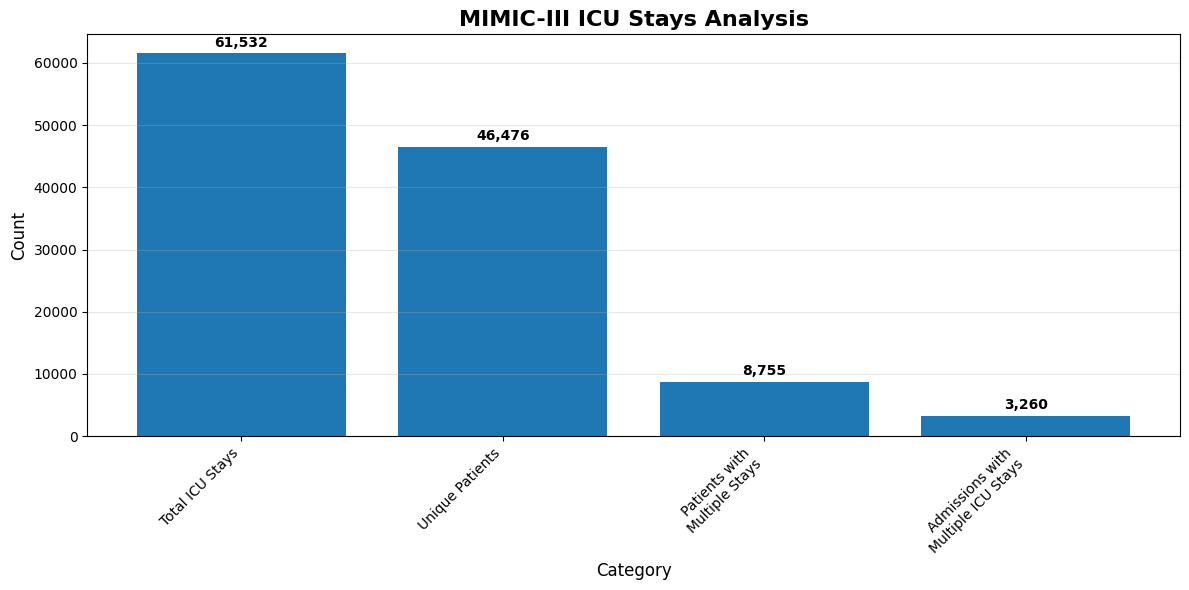

In [12]:
from google.cloud import bigquery
import matplotlib.pyplot as plt

client = bigquery.Client()

def get_scalar(query):
    return list(client.query(query).result())[0][0]

# Obter os valores diretamente de BigQuery
total_stays = get_scalar("SELECT COUNT(*) FROM `bqproject-461521.ICU.tab_icuStays`")
unique_patients = get_scalar("SELECT COUNT(DISTINCT SUBJECT_ID) FROM `bqproject-461521.ICU.tab_icuStays`")
patients_with_multiple_stays = get_scalar("""
    SELECT COUNT(*) FROM (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
admissions_with_multiple_icu_stays = get_scalar("""
    SELECT COUNT(*) FROM (
        SELECT HADM_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY HADM_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")

# Preparar os dados para o gráfico
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']
values = [
    total_stays,
    unique_patients,
    patients_with_multiple_stays,
    admissions_with_multiple_icu_stays
]

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Adicionar os valores acima de cada barra
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Personalizações
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
stats = {
    "total_stays": total_stays,
    "unique_patients": unique_patients,
    "patients_with_multiple_stays": patients_with_multiple_stays,
    "admissions_with_multiple_icu_stays": admissions_with_multiple_icu_stays
}
print(stats)


{'total_stays': 61532, 'unique_patients': 46476, 'patients_with_multiple_stays': 8755, 'admissions_with_multiple_icu_stays': 3260}


### Let's join ICUSTAYS and ADMISSIONS table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't


In [14]:
# Destination table name
destination_table = "bqproject-461521.ICU.tab_icu_with_admissions"

# Query that generates the joined result
query = """
SELECT
  i.*,
  a.ADMITTIME,
  a.DISCHTIME,
  a.DEATHTIME,
  a.ETHNICITY,
  a.DIAGNOSIS,
  a.ADMISSION_TYPE,
  a.ADMISSION_LOCATION,
  a.DISCHARGE_LOCATION,
  a.INSURANCE,
  a.LANGUAGE,
  a.MARITAL_STATUS,
  a.RELIGION
FROM
  `bqproject-461521.ICU.tab_icuStays` AS i
LEFT JOIN
  `bqproject-461521.ICU.tab_admissions` AS a
ON
  i.SUBJECT_ID = a.SUBJECT_ID
  AND i.HADM_ID = a.HADM_ID
"""

# Define the job config to create a new table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"  # Overwrites the table if it exists
)

# Run the query and wait for completion
query_job = client.query(query, job_config=job_config)
query_job.result()  # Wait for job to finish

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_icu_with_admissions


In [15]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_with_admissions`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 326, 'SUBJECT_ID': 236, 'HADM_ID': 191151, 'ICUSTAY_ID': 227008, 'DBSOURCE': 'metavision', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2139, 3, 20, 19, 43, 20, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2139, 3, 22, 15, 51, 23, tzinfo=datetime.timezone.utc), 'LOS': 1.8389, 'ADMITTIME': datetime.datetime(2139, 2, 18, 14, 26, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2139, 4, 8, 15, 30, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'PATIENT DECLINED TO ANSWER', 'DIAGNOSIS': '? PNA INFILTRATE', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'CLINIC REFERRAL/PREMATURE', 'DISCHARGE_LOCATION': 'HOME HEALTH CARE', 'INSURANCE': 'Private', 'LANGUAGE': 'ENGL', 'MARITAL_STATUS': 'MARRIED', 'RELIGION': 'CATHOLIC'}
{'ROW_ID': 2832, 'SUBJECT_ID': 2243, 'HADM_ID': 176457, 'ICUSTAY_ID': 255769, 'DBSOURCE': 'carevue', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU

In [16]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_with_admissions`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_with_admissions: {total:,}")


Total entries in tab_icu_with_admissions: 61,532


#### Now we join the complete ICU data with the PATIENTS info


In [17]:
# Destination table name for the full joined data
destination_table = "bqproject-461521.ICU.tab_icu_full_patient_info"

# Join query
query = """
SELECT
  icu.*,
  p.GENDER,
  p.DOB,
  p.DOD,
  p.DOD_HOSP,
  p.DOD_SSN,
  p.EXPIRE_FLAG
FROM
  `bqproject-461521.ICU.tab_icu_with_admissions` AS icu
LEFT JOIN
  `bqproject-461521.ICU.tab_Patients` AS p
ON
  icu.SUBJECT_ID = p.SUBJECT_ID
"""

# Define job config to write results to a table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"  # Overwrites the table if it exists
)

# Run and wait for completion
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_icu_full_patient_info


In [18]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_full_patient_info`
LIMIT 5
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 55141, 'SUBJECT_ID': 80891, 'HADM_ID': 196778, 'ICUSTAY_ID': 268185, 'DBSOURCE': 'metavision', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2131, 10, 7, 11, 57, 5, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2131, 10, 12, 22, 31, 30, tzinfo=datetime.timezone.utc), 'LOS': 5.4406, 'ADMITTIME': datetime.datetime(2131, 10, 7, 8, 58, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2131, 10, 14, 14, 25, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'HISPANIC OR LATINO', 'DIAGNOSIS': ' STEMI', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'TRANSFER FROM HOSP/EXTRAM', 'DISCHARGE_LOCATION': 'HOME HEALTH CARE', 'INSURANCE': 'Government', 'LANGUAGE': 'ENGL', 'MARITAL_STATUS': 'DIVORCED', 'RELIGION': 'CATHOLIC', 'GENDER': 'F', 'DOB': datetime.datetime(2075, 6, 24, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'DOD_HOSP': None, 'DOD_SSN': None, 'EXPIRE_FLAG': 0}


In [19]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_full_patient_info`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_full_patient_info: {total:,}")


Total entries in tab_icu_full_patient_info: 61,532


#### join the DIAGNOSES and D_ICD_DIAGNOSES tables to get diagnoses descriptions based on the ICD9 code



In [20]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_d_icd_diagnoses`
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 5120, 'ICD9_CODE': '4957', 'SHORT_TITLE': '"ventilation" pneumonit', 'LONG_TITLE': '"Ventilation" pneumonitis'}
{'ROW_ID': 11159, 'ICD9_CODE': '94416', 'SHORT_TITLE': '1 deg burn back of hand', 'LONG_TITLE': 'Erythema [first degree] of back of hand'}
{'ROW_ID': 11157, 'ICD9_CODE': '94414', 'SHORT_TITLE': '1 deg burn fingr w thumb', 'LONG_TITLE': 'Erythema [first degree] of two or more digits of hand including thumb'}
{'ROW_ID': 3658, 'ICD9_CODE': '36911', 'SHORT_TITLE': '1 eye-sev/oth-blind NOS', 'LONG_TITLE': 'Better eye: severe vision impairment; lesser eye: blind, not further specified'}
{'ROW_ID': 12505, 'ICD9_CODE': '94811', 'SHORT_TITLE': '10-19% bdy brn/10-19% 3d', 'LONG_TITLE': 'Burn [any degree] involving 10-19 percent of body surface with third degree burn, 10-19%'}
{'ROW_ID': 12504, 'ICD9_CODE': '94810', 'SHORT_TITLE': '10-19% bdy brn/3 deg NOS', 'LONG_TITLE': 'Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent o

In [21]:
# Destination table
destination_table = "bqproject-461521.ICU.tab_diagnoses_full"

# Query to join and exclude SHORT_TITLE
query = """
SELECT
  d.*,
  dd.LONG_TITLE
FROM
  `bqproject-461521.ICU.tab_diagnoses` AS d
LEFT JOIN
  `bqproject-461521.ICU.tab_d_icd_diagnoses` AS dd
ON
  d.ICD9_CODE = dd.ICD9_CODE

  
"""

# Configure job to write to new table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

# Execute query and wait
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_diagnoses_full


In [22]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_diagnoses_full`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 148860, 'SUBJECT_ID': 13262, 'HADM_ID': 160049, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 131932, 'SUBJECT_ID': 11740, 'HADM_ID': 129620, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 16813, 'SUBJECT_ID': 1490, 'HADM_ID': 135580, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 278820, 'SUBJECT_ID': 24975, 'HADM_ID': 109963, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 315693, 'SUBJECT_ID': 27934, 'HADM_ID': 152077, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 349152, 'SUBJECT_ID': 30405, 'HADM_ID': 154166, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 180428, 'SUBJECT_ID': 16213, 'HADM_ID': 199739, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 112265, 'SUBJECT_ID': 9998, 'HADM_ID': 108282, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 110935, 'SUBJECT_ID': 9896, 'HADM_ID': 171183, 'SEQ_NUM': None, 'ICD9_CO

In [23]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_diagnoses_full`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_diagnoses_full: {total:,}")


Total entries in tab_diagnoses_full: 651,047


#### Now the PATIENT and DIAGNOSES data

In [24]:
# Nome da tabela destino
destination_table = "bqproject-461521.ICU.tab_icu_full_with_diagnoses"

# Query para juntar PATIENT + DIAGNOSES
query = """
SELECT
  p.*,
  d.ICD9_CODE,
  d.LONG_TITLE
FROM
  `bqproject-461521.ICU.tab_icu_full_patient_info` AS p
LEFT JOIN
  `bqproject-461521.ICU.tab_diagnoses_full` AS d
ON
  p.SUBJECT_ID = d.SUBJECT_ID
  AND p.HADM_ID = d.HADM_ID
"""

# Configurar job para gravar tabela
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

# Executar e aguardar conclusão
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Tabela criada com sucesso: {destination_table}")

Tabela criada com sucesso: bqproject-461521.ICU.tab_icu_full_with_diagnoses


In [25]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 17, 'SUBJECT_ID': 18, 'HADM_ID': 188822, 'ICUSTAY_ID': 298129, 'DBSOURCE': 'carevue', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2167, 10, 2, 11, 20, 39, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2167, 10, 3, 18, 16, 5, tzinfo=datetime.timezone.utc), 'LOS': 1.2885, 'ADMITTIME': datetime.datetime(2167, 10, 2, 11, 18, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2167, 10, 4, 16, 15, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'WHITE', 'DIAGNOSIS': 'HYPOGLYCEMIA;SEIZURES', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'PHYS REFERRAL/NORMAL DELI', 'DISCHARGE_LOCATION': 'HOME', 'INSURANCE': 'Private', 'LANGUAGE': None, 'MARITAL_STATUS': 'MARRIED', 'RELIGION': 'CATHOLIC', 'GENDER': 'M', 'DOB': datetime.datetime(2116, 11, 29, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'DOD_HOSP': None, 'DOD_SSN': None, 'EXPIRE_FLAG': 0, 'ICD9_CODE': '29633', 'LO

In [26]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_full_with_diagnoses: {total:,}")


Total entries in tab_icu_full_with_diagnoses: 705,921


### Binary Diagnosis Features from ICD-9 Codes

This cell creates a BigQuery table that maps ICD-9 codes to binary diagnostic categories (e.g., infectious, malignancy, cardiovascular, etc.). Each `ICUSTAY_ID` is assigned binary indicators based on the presence of ICD-9 codes falling within predefined ranges.

It also calculates the percentage of ICU stays that include at least one diagnosis in each category, helping to identify the most common types of conditions in the dataset.


In [27]:


# Fixed query with correct column name
create_diag_features_query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_icu_diag_features_complete` AS
WITH 
-- Step 1: Get base data (equivalent to base_data in PySpark)
base_data AS (
  SELECT DISTINCT
    ICUSTAY_ID,
    SUBJECT_ID,
    HADM_ID,
    INTIME,
    OUTTIME,
    LOS,
    ADMITTIME,
    DISCHTIME,
    DEATHTIME,
    ADMISSION_TYPE,
    DIAGNOSIS,  -- Fixed: Use DIAGNOSIS instead of ADMISSION_DIAGNOSIS
    GENDER,
    DOB,
    DOD,
    EXPIRE_FLAG
  FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
),

-- Step 2: Create diagnosis features from non-null ICD9_CODE records
diagnosis_binarized AS (
  SELECT
    ICUSTAY_ID,
    ICD9_CODE,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])'), 1, 0) AS has_infectious,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(1[4-9][0-9]|2[0-3][0-9])'), 1, 0) AS has_malignancy,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(2[4-7][0-9])'), 1, 0) AS has_endocrine,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(2[8-9][0-9])'), 1, 0) AS has_hematologic,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(29[0-9]|30[0-9]|31[0-9])'), 1, 0) AS has_psychiatric,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])'), 1, 0) AS has_neurological,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])'), 1, 0) AS has_cardiovascular,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])'), 1, 0) AS has_respiratory,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])'), 1, 0) AS has_gastrointestinal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])'), 1, 0) AS has_genitourinary,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])'), 1, 0) AS has_obstetric,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(68[0-9]|69[0-9]|70[0-9])'), 1, 0) AS has_skin,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(71[0-9]|72[0-9]|73[0-9])'), 1, 0) AS has_musculoskeletal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(74[0-9]|75[0-9])'), 1, 0) AS has_congenital,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(76[0-9]|77[0-9])'), 1, 0) AS has_perinatal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(78[0-9]|79[0-9])'), 1, 0) AS has_symptoms_signs,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(8[0-9][0-9]|9[0-9][0-9])'), 1, 0) AS has_trauma,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^E'), 1, 0) AS has_external_causes,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^V'), 1, 0) AS has_supplemental
  FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
  WHERE ICD9_CODE IS NOT NULL
),

-- Step 3: Aggregate diagnosis features by ICUSTAY_ID
diagnosis_features AS (
  SELECT
    ICUSTAY_ID,
    MAX(has_infectious) AS has_infectious,
    MAX(has_malignancy) AS has_malignancy,
    MAX(has_endocrine) AS has_endocrine,
    MAX(has_hematologic) AS has_hematologic,
    MAX(has_psychiatric) AS has_psychiatric,
    MAX(has_neurological) AS has_neurological,
    MAX(has_cardiovascular) AS has_cardiovascular,
    MAX(has_respiratory) AS has_respiratory,
    MAX(has_gastrointestinal) AS has_gastrointestinal,
    MAX(has_genitourinary) AS has_genitourinary,
    MAX(has_obstetric) AS has_obstetric,
    MAX(has_skin) AS has_skin,
    MAX(has_musculoskeletal) AS has_musculoskeletal,
    MAX(has_congenital) AS has_congenital,
    MAX(has_perinatal) AS has_perinatal,
    MAX(has_symptoms_signs) AS has_symptoms_signs,
    MAX(has_trauma) AS has_trauma,
    MAX(has_external_causes) AS has_external_causes,
    MAX(has_supplemental) AS has_supplemental,
    COUNT(ICD9_CODE) AS total_diagnoses
  FROM diagnosis_binarized
  GROUP BY ICUSTAY_ID
)

-- Step 4: Join base data with diagnosis features
SELECT 
  bd.*,
  COALESCE(df.has_infectious, 0) AS has_infectious,
  COALESCE(df.has_malignancy, 0) AS has_malignancy,
  COALESCE(df.has_endocrine, 0) AS has_endocrine,
  COALESCE(df.has_hematologic, 0) AS has_hematologic,
  COALESCE(df.has_psychiatric, 0) AS has_psychiatric,
  COALESCE(df.has_neurological, 0) AS has_neurological,
  COALESCE(df.has_cardiovascular, 0) AS has_cardiovascular,
  COALESCE(df.has_respiratory, 0) AS has_respiratory,
  COALESCE(df.has_gastrointestinal, 0) AS has_gastrointestinal,
  COALESCE(df.has_genitourinary, 0) AS has_genitourinary,
  COALESCE(df.has_obstetric, 0) AS has_obstetric,
  COALESCE(df.has_skin, 0) AS has_skin,
  COALESCE(df.has_musculoskeletal, 0) AS has_musculoskeletal,
  COALESCE(df.has_congenital, 0) AS has_congenital,
  COALESCE(df.has_perinatal, 0) AS has_perinatal,
  COALESCE(df.has_symptoms_signs, 0) AS has_symptoms_signs,
  COALESCE(df.has_trauma, 0) AS has_trauma,
  COALESCE(df.has_external_causes, 0) AS has_external_causes,
  COALESCE(df.has_supplemental, 0) AS has_supplemental,
  COALESCE(df.total_diagnoses, 0) AS total_diagnoses

FROM base_data bd
LEFT JOIN diagnosis_features df
  ON bd.ICUSTAY_ID = df.ICUSTAY_ID;
"""

# Execute the corrected query
print("Creating complete diagnosis features table...")
client.query(create_diag_features_query).result()
print("Table 'tab_icu_diag_features_complete' created successfully!")

Creating complete diagnosis features table...
Table 'tab_icu_diag_features_complete' created successfully!


In [28]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ICUSTAY_ID': 243350, 'SUBJECT_ID': 333, 'HADM_ID': 160548, 'INTIME': datetime.datetime(2137, 9, 29, 6, 3, 25, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2137, 10, 1, 14, 15, 47, tzinfo=datetime.timezone.utc), 'LOS': 2.3419, 'ADMITTIME': datetime.datetime(2137, 9, 29, 4, 45, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2137, 10, 2, 16, 25, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ADMISSION_TYPE': 'EMERGENCY', 'DIAGNOSIS': 'INSTEMI\\CARDIAC CATH', 'GENDER': 'F', 'DOB': datetime.datetime(2072, 4, 8, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'EXPIRE_FLAG': 0, 'has_infectious': 0, 'has_malignancy': 0, 'has_endocrine': 0, 'has_hematologic': 0, 'has_psychiatric': 0, 'has_neurological': 0, 'has_cardiovascular': 1, 'has_respiratory': 0, 'has_gastrointestinal': 0, 'has_genitourinary': 0, 'has_obstetric': 0, 'has_skin': 0, 'has_musculoskeletal': 0, 'has_congenital': 0, 'has_perinatal': 0, 'has_symptoms_signs': 0, 'has_trauma': 0, 'has_external

In [29]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_diag_features_complete: {total:,}")


Total entries in tab_icu_diag_features_complete: 61,532


### Visualization of Diagnosis Categories (ICD-9)

This section queries the BigQuery table `tab_icu_diag_features` to retrieve the number and percentage of ICU stays associated with various ICD-9 diagnosis categories (e.g., infectious, malignancy, cardiovascular).

The output includes:
- A **horizontal bar chart** showing the absolute number of ICU patients per diagnostic category.
- A **percentage-based bar chart** showing the relative frequency of each category.
- A textual summary identifying the most and least common categories.

This helps to understand the distribution of clinical conditions among ICU patients.


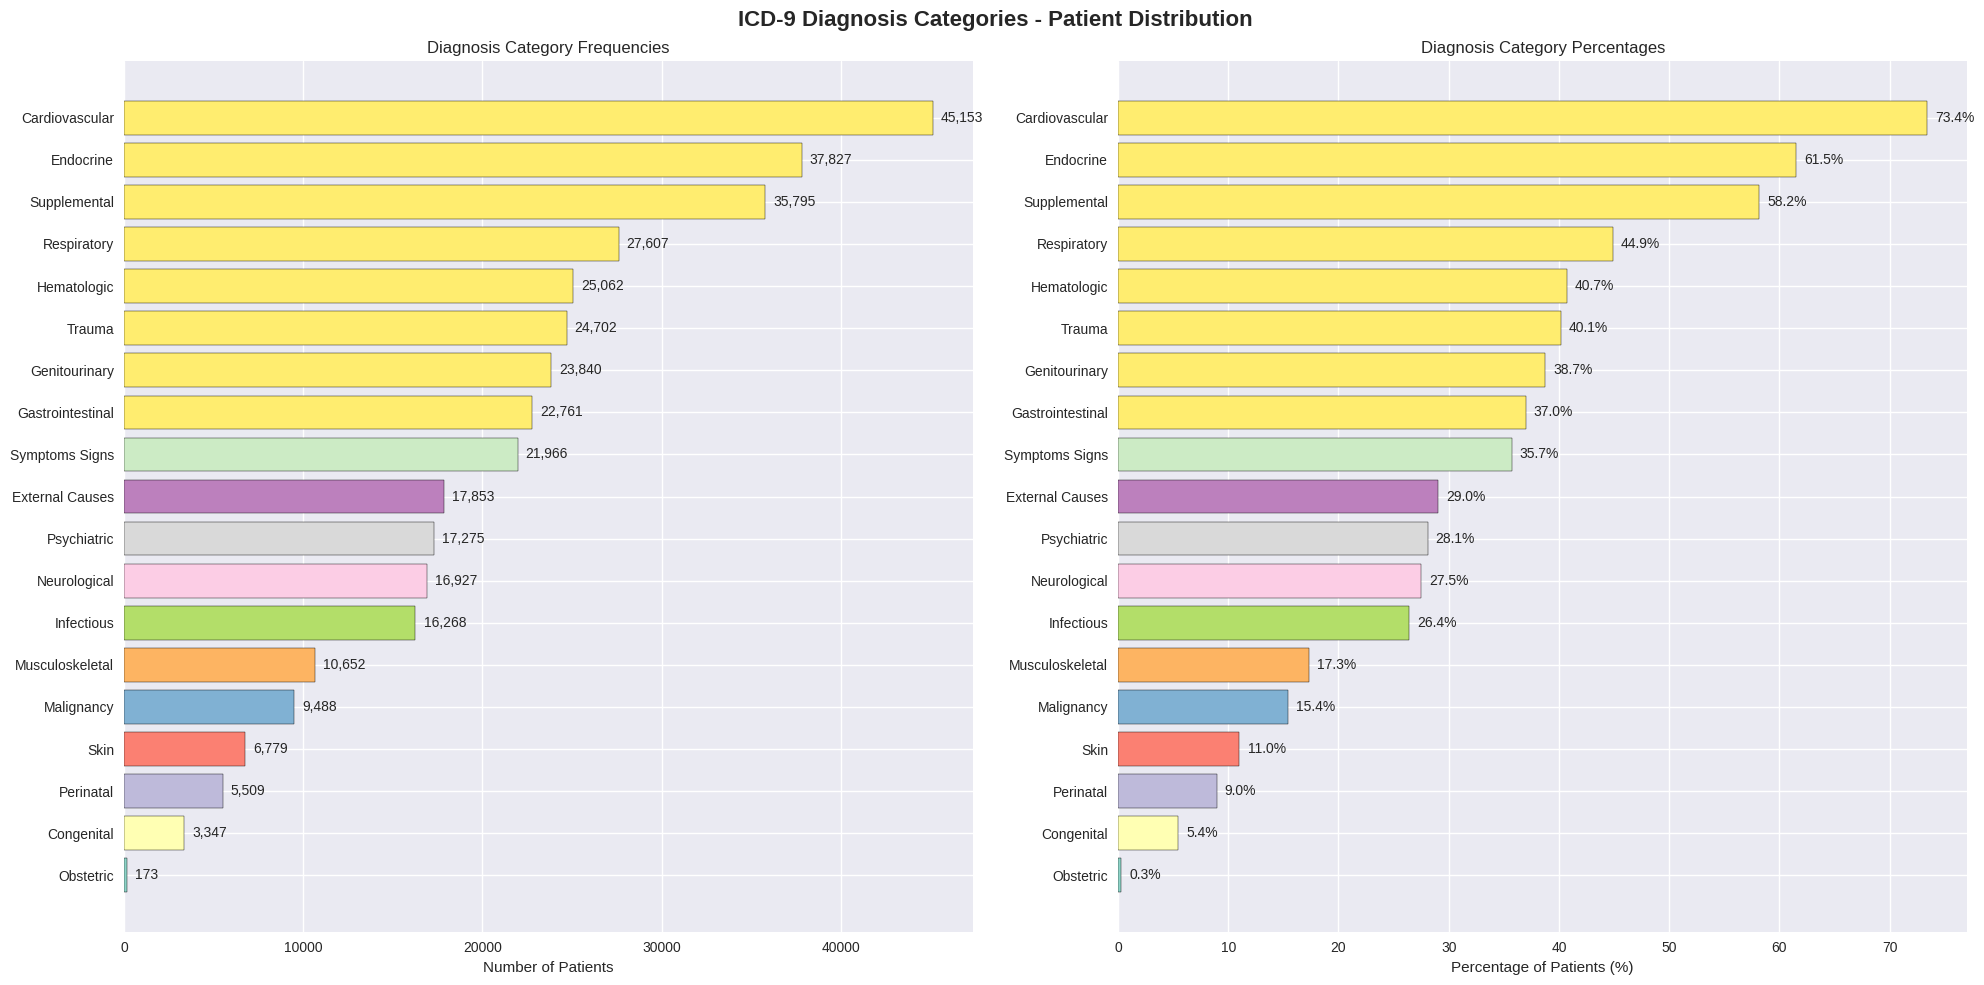


Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery

# Conexão BigQuery
client = bigquery.Client(project="bqproject-461521")

# Diagnóstico binário para cada categoria
diagnosis_cols = [
    "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
    "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
    "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
    "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
    "has_trauma", "has_external_causes", "has_supplemental"
]

# Construir a query dinâmica
select_exprs = ",\n  ".join([f"SUM({col}) AS {col}" for col in diagnosis_cols])
query = f"""
SELECT
  COUNT(*) AS total_patients,
  {select_exprs}
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
"""

# Executar e obter os resultados
result = client.query(query).result()
row = list(result)[0]
total_patients = row["total_patients"]

# Construir DataFrame
category_counts = []
for col in diagnosis_cols:
    count = row[col] or 0
    category_counts.append({
        "category": col.replace("has_", "").replace("_", " ").title(),
        "count": count,
        "percentage": (count / total_patients) * 100
    })

df = pd.DataFrame(category_counts)
df = df.sort_values("count", ascending=True)

# Plot
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('ICD-9 Diagnosis Categories - Patient Distribution', fontsize=16, fontweight='bold')

# Plot 1 - contagem
colors = plt.cm.Set3(range(len(df)))
bars1 = ax1.barh(df["category"], df["count"], color=colors, edgecolor='black')
ax1.set_xlabel("Number of Patients")
ax1.set_title("Diagnosis Category Frequencies")
for i, bar in enumerate(bars1):
    ax1.text(bar.get_width() + max(df["count"]) * 0.01, bar.get_y() + bar.get_height()/2, f"{int(bar.get_width()):,}", va='center')

# Plot 2 - percentagens
bars2 = ax2.barh(df["category"], df["percentage"], color=colors, edgecolor='black')
ax2.set_xlabel("Percentage of Patients (%)")
ax2.set_title("Diagnosis Category Percentages")
for i, bar in enumerate(bars2):
    ax2.text(bar.get_width() + max(df["percentage"]) * 0.01, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.1f}%", va='center')

plt.tight_layout()
plt.show()

# Print resumo
print(f"\nTotal ICU patients analyzed: {total_patients:,}")
print(f"Most common diagnosis category: {df.iloc[-1]['category']} ({df.iloc[-1]['percentage']:.1f}%)")
print(f"Least common diagnosis category: {df.iloc[0]['category']} ({df.iloc[0]['percentage']:.1f}%)")


### CHART EVENTS and D_ITEMS join

In [31]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_chartevents`
LIMIT 10
"""

result = client.query(query).result()
rows = [dict(row) for row in result]

print("\n=== Preview: chart_events_df.show(5) ===")
for row in rows:
    print(row)



=== Preview: chart_events_df.show(5) ===
{'ROW_ID': 134356372, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 677, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31, 17, 40), 'CGID': 15225, 'VALUE': '37.944400787353516', 'VALUENUM': 37.944400787353516, 'VALUEUOM': 'Deg. C', 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd'}
{'ROW_ID': 134356373, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 678, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31, 17, 40), 'CGID': 15225, 'VALUE': '100.30000305175781', 'VALUENUM': 100.30000305175781, 'VALUEUOM': 'Deg. F', 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd'}
{'ROW_ID': 134356374, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 742, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31

In [32]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_d_items`
"""

result = client.query(query).result()
rows = [dict(row) for row in result]

print("\n=== Preview: d_items_df.show(5) ===")
for row in rows:
    print(row)


=== Preview: d_items_df.show(5) ===
{'ROW_ID': 457, 'ITEMID': 497, 'LABEL': 'Patient controlled analgesia (PCA) [Inject]', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 458, 'ITEMID': 498, 'LABEL': 'PCA Lockout (Min)', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 459, 'ITEMID': 499, 'LABEL': 'PCA Medication', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 460, 'ITEMID': 500, 'LABEL': 'PCA Total Dose', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 461, 'ITEMID': 501, 'LABEL': 'PCV Exh Vt (Obser)', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO

In [33]:
destination_table = "bqproject-461521.ICU.tab_chartevents_with_labels"

query = """
SELECT
  c.*,
  d.LABEL,
  d.ABBREVIATION,
  d.UNITNAME,
  d.LINKSTO,
  d.CATEGORY,
  d.PARAM_TYPE
FROM
  `bqproject-461521.ICU.tab_chartevents` AS c
LEFT JOIN
  `bqproject-461521.ICU.tab_d_items` AS d
ON
  c.ITEMID = d.ITEMID
"""

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Tabela criada com sucesso: {destination_table}")


Tabela criada com sucesso: bqproject-461521.ICU.tab_chartevents_with_labels


In [34]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 258869127, 'SUBJECT_ID': 69789, 'HADM_ID': 130495, 'ICUSTAY_ID': 235469, 'ITEMID': 227292, 'CHARTTIME': datetime.datetime(2139, 6, 28, 8, 44), 'STORETIME': datetime.datetime(2139, 6, 28, 8, 45), 'CGID': 20220, 'VALUE': '1', 'VALUENUM': 1.0, 'VALUEUOM': None, 'WARNING': 0, 'ERROR': 0, 'RESULTSTATUS': None, 'STOPPED': None, 'LABEL': 'Arterial Line Dressing Occlusive', 'ABBREVIATION': 'Arterial Line Dressing Occlusive', 'UNITNAME': None, 'LINKSTO': 'chartevents', 'CATEGORY': 'Access Lines - Invasive', 'PARAM_TYPE': 'Checkbox'}
{'ROW_ID': 258852452, 'SUBJECT_ID': 69654, 'HADM_ID': 126913, 'ICUSTAY_ID': 286946, 'ITEMID': 225082, 'CHARTTIME': datetime.datetime(2155, 6, 23, 18, 29), 'STORETIME': datetime.datetime(2155, 6, 23, 18, 30), 'CGID': 19326, 'VALUE': '0', 'VALUENUM': 0.0, 'VALUEUOM': None, 'WARNING': 0, 'ERROR': 0, 'RESULTSTATUS': None, 'STOPPED': None, 'LABEL': 'Pregnant', 'ABBREVIATION': 'Pregnant', 'UNITNAME': None, 'LINKSTO': 'chartevents', 'CATEGORY': 'Adm History/FHPA

In [35]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_chartevents_with_labels: {total:,}")


Total entries in tab_chartevents_with_labels: 330,712,483


### Hourly Vitals Table using UNION + PIVOT (BigQuery)

This query constructs a new table `tab_hourly_vitals` by:
- Combining heart rate (`ITEMID = 211`), respiratory rate (`ITEMID = 618`), and SpO₂ (`ITEMID = 646`) measurements.
- Truncating each measurement timestamp to the hour level (`TIMESTAMP_TRUNC`).
- Labeling each signal with a `signal_type` and unifying all values with `UNION ALL`.
- Applying a `PIVOT` operation to reshape the data into columns for each signal type with hourly averages.

This table allows convenient analysis of time-aligned, hourly-aggregated vitals for each ICU stay.


In [36]:
query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_hourly_vitals` AS
WITH union_signals AS (
  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'heart_rate' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 211 AND VALUENUM IS NOT NULL

  UNION ALL

  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'resp_rate' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 618 AND VALUENUM IS NOT NULL

  UNION ALL

  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'spo2' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 646 AND VALUENUM IS NOT NULL
)
SELECT *
FROM union_signals
PIVOT (
  AVG(value) FOR signal_type IN ('heart_rate', 'resp_rate', 'spo2')
)

"""

# Executar query (sem destination)
client.query(query).result()
print("Tabela 'tab_hourly_vitals' criada com sucesso")


Tabela 'tab_hourly_vitals' criada com sucesso


In [37]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_hourly_vitals`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_hourly_vitals: {total:,}")


Total entries in tab_hourly_vitals: 4,582,400


### Table `tab_hourly_vitals_avg_24h`: Average Vital Signs in First 24 Hours of ICU Stay

This query creates the `tab_hourly_vitals_avg_24h` table, which contains the average values of key vital signs recorded during the first 24 hours of each ICU stay.

**Steps performed:**
1. Join hourly vital signs (`tab_hourly_vitals`) with ICU admission time from `tab_icu_adm_pat`.
2. Compute the number of hours since ICU admission for each measurement.
3. Filter records within the first 24 hours (`hours_since_admit BETWEEN 0 AND 24`).
4. Calculate the average heart rate, respiratory rate, and SpO₂ within that window.
5. If SpO₂ data is missing for a patient, fill it with the global average SpO₂ (computed from all available data).

**Output columns:**
- `ICUSTAY_ID`
- `avg_heart_rate_24h`
- `avg_resp_rate_24h`
- `avg_spo2_24h` (with fallback if missing)

**Purpose:**  
This table is useful for early clinical risk modeling and outcome prediction using early physiological signals.


In [38]:
from google.cloud import bigquery

client = bigquery.Client(project="bqproject-461521")

query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_hourly_vitals_stats_24h` AS
WITH base_data AS (
  SELECT
    hv.ICUSTAY_ID,
    hv.charttime_hour,
    hv.heart_rate,
    hv.resp_rate,
    hv.spo2,
    p.INTIME,
    DATETIME_DIFF(hv.charttime_hour, DATETIME(p.INTIME), HOUR) AS hours_from_intime
  FROM `bqproject-461521.ICU.tab_hourly_vitals` hv
  JOIN `bqproject-461521.ICU.tab_icu_full_patient_info` p
    ON hv.ICUSTAY_ID = p.ICUSTAY_ID
),
first_24h AS (
  SELECT *
  FROM base_data
  WHERE hours_from_intime BETWEEN 0 AND 24
),
flattened AS (
  SELECT ICUSTAY_ID, 'heart_rate' AS signal, heart_rate AS value FROM first_24h WHERE heart_rate IS NOT NULL
  UNION ALL
  SELECT ICUSTAY_ID, 'resp_rate', resp_rate FROM first_24h WHERE resp_rate IS NOT NULL
  UNION ALL
  SELECT ICUSTAY_ID, 'spo2', spo2 FROM first_24h WHERE spo2 IS NOT NULL
),
aggregated AS (
  SELECT
    ICUSTAY_ID,
    signal,
    AVG(value) AS avg_value,
    MIN(value) AS min_value,
    MAX(value) AS max_value,
    STDDEV(value) AS std_value,
    COUNT(value) AS count_value
  FROM flattened
  GROUP BY ICUSTAY_ID, signal
),
pivoted AS (
  SELECT
    ICUSTAY_ID,
    MAX(IF(signal = 'heart_rate', avg_value, NULL)) AS heart_rate_avg,
    MAX(IF(signal = 'heart_rate', min_value, NULL)) AS heart_rate_min,
    MAX(IF(signal = 'heart_rate', max_value, NULL)) AS heart_rate_max,
    MAX(IF(signal = 'heart_rate', std_value, NULL)) AS heart_rate_std,
    MAX(IF(signal = 'heart_rate', count_value, NULL)) AS heart_rate_count,
    
    MAX(IF(signal = 'resp_rate', avg_value, NULL)) AS respiratory_rate_avg,
    MAX(IF(signal = 'resp_rate', min_value, NULL)) AS respiratory_rate_min,
    MAX(IF(signal = 'resp_rate', max_value, NULL)) AS respiratory_rate_max,
    MAX(IF(signal = 'resp_rate', std_value, NULL)) AS respiratory_rate_std,
    MAX(IF(signal = 'resp_rate', count_value, NULL)) AS respiratory_rate_count,
    
    MAX(IF(signal = 'spo2', avg_value, NULL)) AS spo2_avg,
    MAX(IF(signal = 'spo2', min_value, NULL)) AS spo2_min,
    MAX(IF(signal = 'spo2', max_value, NULL)) AS spo2_max,
    MAX(IF(signal = 'spo2', std_value, NULL)) AS spo2_std,
    MAX(IF(signal = 'spo2', count_value, NULL)) AS spo2_count
  FROM aggregated
  GROUP BY ICUSTAY_ID
)
SELECT * FROM pivoted
"""

# Execute query
client.query(query).result()
print("Table 'tab_hourly_vitals_stats_24h' created with full vital sign stats for the first 24h.")


Table 'tab_hourly_vitals_stats_24h' created with full vital sign stats for the first 24h.


In [39]:
from google.cloud import bigquery
import time

client = bigquery.Client(project="bqproject-461521")

query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.vital_signs_first_24h` AS
WITH chartevents_with_intime AS (
  -- Join chartevents with ICU stays to get admission time
  SELECT 
    ce.*,
    icu.INTIME,
    -- Calculate hours from ICU admission (fixed datetime conversion)
    DATETIME_DIFF(
      DATETIME(TIMESTAMP(ce.CHARTTIME)), 
      DATETIME(TIMESTAMP(icu.INTIME)), 
      HOUR
    ) AS hours_from_intime
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels` AS ce
  INNER JOIN `bqproject-461521.ICU.tab_icuStays` AS icu
    ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
  WHERE ce.ICUSTAY_ID IS NOT NULL
    AND ce.VALUENUM IS NOT NULL
    AND ce.ITEMID IN (211, 618, 646)  -- Heart rate, Respiratory rate, SpO2
),

first_24h_vitals AS (
  -- Filter to first 24 hours only
  SELECT *
  FROM chartevents_with_intime
  WHERE hours_from_intime >= 0 
    AND hours_from_intime <= 24
),

vital_signs_stats AS (
  -- Calculate statistics for each vital sign and ICU stay
  SELECT 
    ICUSTAY_ID,
    
    -- Heart Rate (ITEMID = 211)
    AVG(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_avg,
    MIN(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_min,
    MAX(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_max,
    STDDEV(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_std,
    COUNT(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_count,
    
    -- Respiratory Rate (ITEMID = 618)
    AVG(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_avg,
    MIN(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_min,
    MAX(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_max,
    STDDEV(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_std,
    COUNT(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_count,
    
    -- SpO2 (ITEMID = 646)
    AVG(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_avg,
    MIN(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_min,
    MAX(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_max,
    STDDEV(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_std,
    COUNT(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_count
    
  FROM first_24h_vitals
  GROUP BY ICUSTAY_ID
)

-- Final result with all ICU stays (left join to include stays without vital signs)
SELECT 
  icu.ICUSTAY_ID,
  
  -- Heart Rate features
  vs.heart_rate_avg,
  vs.heart_rate_min,
  vs.heart_rate_max,
  vs.heart_rate_std,
  COALESCE(vs.heart_rate_count, 0) AS heart_rate_count,
  
  -- Respiratory Rate features
  vs.respiratory_rate_avg,
  vs.respiratory_rate_min,
  vs.respiratory_rate_max,
  vs.respiratory_rate_std,
  COALESCE(vs.respiratory_rate_count, 0) AS respiratory_rate_count,
  
  -- SpO2 features
  vs.spo2_avg,
  vs.spo2_min,
  vs.spo2_max,
  vs.spo2_std,
  COALESCE(vs.spo2_count, 0) AS spo2_count

FROM `bqproject-461521.ICU.tab_icuStays` AS icu
LEFT JOIN vital_signs_stats AS vs
  ON icu.ICUSTAY_ID = vs.ICUSTAY_ID;
"""

print("Creating vital signs table...")
start_time = time.time()

try:
    job = client.query(query)
    job.result()  # Wait for completion
    
    end_time = time.time()
    
    # Get row count
    count_query = "SELECT COUNT(*) as count FROM `bqproject-461521.ICU.vital_signs_first_24h`"
    count_result = client.query(count_query).result()
    row_count = list(count_result)[0].count
    
    print(f" Table 'vital_signs_first_24h' successfully created!")
    print(f"   Rows created: {row_count:,}")
    print(f"   Time taken: {end_time - start_time:.2f} seconds")
    
    # Quick coverage check
    coverage_query = """
    SELECT 
      COUNT(*) as total_icu_stays,
      SUM(CASE WHEN heart_rate_count > 0 THEN 1 ELSE 0 END) as with_heart_rate,
      SUM(CASE WHEN respiratory_rate_count > 0 THEN 1 ELSE 0 END) as with_resp_rate,
      SUM(CASE WHEN spo2_count > 0 THEN 1 ELSE 0 END) as with_spo2
    FROM `bqproject-461521.ICU.vital_signs_first_24h`
    """
    
    coverage_result = client.query(coverage_query).result()
    coverage_data = list(coverage_result)[0]
    
    print(f"\nCoverage Summary:")
    print(f"   Total ICU stays: {coverage_data.total_icu_stays:,}")
    print(f"   With heart rate: {coverage_data.with_heart_rate:,} ({coverage_data.with_heart_rate/coverage_data.total_icu_stays*100:.1f}%)")
    print(f"   With respiratory rate: {coverage_data.with_resp_rate:,} ({coverage_data.with_resp_rate/coverage_data.total_icu_stays*100:.1f}%)")
    print(f"   With SpO2: {coverage_data.with_spo2:,} ({coverage_data.with_spo2/coverage_data.total_icu_stays*100:.1f}%)")
    
except Exception as e:
    print(f"Error creating table: {e}")

Creating vital signs table...
 Table 'vital_signs_first_24h' successfully created!
   Rows created: 61,532
   Time taken: 4.31 seconds

Coverage Summary:
   Total ICU stays: 61,532
   With heart rate: 36,246 (58.9%)
   With respiratory rate: 28,895 (47.0%)
   With SpO2: 28,939 (47.0%)


In [40]:
query = """
SELECT ICUSTAY_ID, charttime_hour, spo2
FROM `bqproject-461521.ICU.tab_hourly_vitals`
WHERE spo2 IS NOT NULL
LIMIT 20
"""

results = client.query(query).result()

for row in results:
    print(dict(row))


{'ICUSTAY_ID': 246522, 'charttime_hour': datetime.datetime(2156, 1, 11, 20, 0), 'spo2': 93.0}
{'ICUSTAY_ID': 208024, 'charttime_hour': datetime.datetime(2182, 3, 22, 12, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 249752, 'charttime_hour': datetime.datetime(2168, 12, 1, 15, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 244029, 'charttime_hour': datetime.datetime(2122, 10, 27, 4, 0), 'spo2': 96.0}
{'ICUSTAY_ID': 286231, 'charttime_hour': datetime.datetime(2116, 12, 4, 1, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 269462, 'charttime_hour': datetime.datetime(2131, 1, 15, 11, 0), 'spo2': 97.0}
{'ICUSTAY_ID': 250326, 'charttime_hour': datetime.datetime(2127, 1, 15, 19, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 228463, 'charttime_hour': datetime.datetime(2110, 11, 11, 7, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 231370, 'charttime_hour': datetime.datetime(2105, 5, 19, 0, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 265873, 'charttime_hour': datetime.datetime(2155, 2, 16, 5, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 225904, 'charttime_hour': datetime.datetime(2

In [41]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_hourly_vitals_avg_24h`
WHERE 
  avg_heart_rate_24h IS NOT NULL AND avg_heart_rate_24h != 0.0
  AND avg_resp_rate_24h IS NOT NULL AND avg_resp_rate_24h != 0.0
  AND avg_spo2_24h IS NOT NULL AND avg_spo2_24h != 0.0
LIMIT 10

"""

results = client.query(query).result()

for row in results:
    print(dict(row))


{'ICUSTAY_ID': 222077, 'avg_heart_rate_24h': 81.34782608695652, 'avg_resp_rate_24h': 10.084848484848482, 'avg_spo2_24h': 20.28571428571429}
{'ICUSTAY_ID': 235872, 'avg_heart_rate_24h': 43.333333333333336, 'avg_resp_rate_24h': 17.999999999999996, 'avg_spo2_24h': 29.833333333333336}
{'ICUSTAY_ID': 200264, 'avg_heart_rate_24h': 57.833333333333336, 'avg_resp_rate_24h': 14.0, 'avg_spo2_24h': 36.97222222222222}
{'ICUSTAY_ID': 239691, 'avg_heart_rate_24h': 132.5115283267457, 'avg_resp_rate_24h': 24.66179183135705, 'avg_spo2_24h': 37.8125}
{'ICUSTAY_ID': 261491, 'avg_heart_rate_24h': 60.0, 'avg_resp_rate_24h': 30.0, 'avg_spo2_24h': 38.800000000000004}
{'ICUSTAY_ID': 203591, 'avg_heart_rate_24h': 60.214285714285715, 'avg_resp_rate_24h': 31.142857142857142, 'avg_spo2_24h': 43.60714285714286}
{'ICUSTAY_ID': 246206, 'avg_heart_rate_24h': 88.09722222222223, 'avg_resp_rate_24h': 22.541666666666664, 'avg_spo2_24h': 44.54166666666667}
{'ICUSTAY_ID': 290418, 'avg_heart_rate_24h': 117.65625, 'avg_resp_r

In [42]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_hourly_vitals_stats_24h`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_hourly_vitals_stats_24h: {total:,}")


Total entries in tab_hourly_vitals_stats_24h: 36,248


### Let's create a table with tab_diagnoses_complete + tab_hourly_vitals_24h 


In [43]:
from google.cloud import bigquery
import time

client = bigquery.Client(project="bqproject-461521")

# Create the final joined table with diagnosis + vital signs + age_at_admission
final_join_query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_final_dataset` AS
SELECT 
  diag.*,
  
  -- Calculate Age at Admission
  -- Ensure ADMITTIME and DOB are not NULL for accurate calculation.
  -- If either ADMITTIME or DOB is NULL, age_at_admission will be NULL.
  CASE 
    WHEN diag.ADMITTIME IS NOT NULL AND diag.DOB IS NOT NULL THEN
      DATE_DIFF(DATE(diag.ADMITTIME), DATE(diag.DOB), YEAR)
    ELSE NULL 
  END AS age_at_admission, -- Added new column
  
  -- Vital signs features (excluding ICUSTAY_ID from vs to avoid ambiguity if it exists there)
  vs.heart_rate_avg,
  vs.heart_rate_min,
  vs.heart_rate_max,
  vs.heart_rate_std,
  vs.heart_rate_count,
  
  vs.respiratory_rate_avg,
  vs.respiratory_rate_min,
  vs.respiratory_rate_max,
  vs.respiratory_rate_std,
  vs.respiratory_rate_count,
  
  vs.spo2_avg,
  vs.spo2_min,
  vs.spo2_max,
  vs.spo2_std,
  vs.spo2_count

FROM `bqproject-461521.ICU.tab_icu_diag_features_complete` AS diag
LEFT JOIN `bqproject-461521.ICU.vital_signs_first_24h` AS vs
  ON diag.ICUSTAY_ID = vs.ICUSTAY_ID;
"""

print("Creating final dataset (diagnosis + vital signs + age_at_admission)...")
start_time_script = time.time() # Renamed to avoid conflict with time module itself

try:
    job = client.query(final_join_query)
    job.result()  # Wait for completion
    
    end_time_script = time.time() # Renamed
    
    # Get row count and basic stats, including age stats
    stats_query = """
    SELECT 
      COUNT(*) as total_rows,
      COUNT(DISTINCT ICUSTAY_ID) as unique_icu_stays,
      
      -- Age stats
      AVG(age_at_admission) as avg_age_at_admission,
      MIN(age_at_admission) as min_age_at_admission,
      MAX(age_at_admission) as max_age_at_admission,
      COUNTIF(age_at_admission IS NULL) as null_age_count,
      
      -- Diagnosis coverage
      SUM(COALESCE(has_cardiovascular, 0)) as patients_with_cardiovascular, -- Added COALESCE for safety
      SUM(COALESCE(has_respiratory, 0)) as patients_with_respiratory,   -- Added COALESCE for safety
      SUM(COALESCE(has_trauma, 0)) as patients_with_trauma,             -- Added COALESCE for safety
      
      -- Vital signs coverage
      SUM(CASE WHEN COALESCE(heart_rate_count, 0) > 0 THEN 1 ELSE 0 END) as with_heart_rate_data,
      SUM(CASE WHEN COALESCE(respiratory_rate_count, 0) > 0 THEN 1 ELSE 0 END) as with_resp_rate_data,
      SUM(CASE WHEN COALESCE(spo2_count, 0) > 0 THEN 1 ELSE 0 END) as with_spo2_data,
      
      -- Complete data (both diagnosis and vital signs and age)
      SUM(CASE WHEN COALESCE(total_diagnoses, 0) > 0 AND COALESCE(heart_rate_count, 0) > 0 AND age_at_admission IS NOT NULL THEN 1 ELSE 0 END) as complete_records_with_age
      
    FROM `bqproject-461521.ICU.tab_final_dataset`
    """
    
    stats_job = client.query(stats_query)
    stats_result = stats_job.result() # Wait for stats query to complete
    
    # Ensure we have results before trying to access them
    stats_list = list(stats_result)
    if not stats_list:
        raise ValueError("Statistics query returned no results.")
    stats = stats_list[0]
    
    print(f"Final dataset created successfully!")
    print(f"   Time taken: {end_time_script - start_time_script:.2f} seconds")
    print(f"   Total rows: {stats.total_rows:,}")
    print(f"   Unique ICU stays: {stats.unique_icu_stays:,}")

    print(f"\n Age at Admission Statistics:")
    if stats.total_rows > 0 : # Avoid division by zero if table is empty
        print(f"   Average Age: {stats.avg_age_at_admission:.1f} years" if stats.avg_age_at_admission is not None else "   Average Age: N/A")
        print(f"   Min Age: {stats.min_age_at_admission:.0f} years" if stats.min_age_at_admission is not None else "   Min Age: N/A")
        print(f"   Max Age: {stats.max_age_at_admission:.0f} years" if stats.max_age_at_admission is not None else "   Max Age: N/A")
        print(f"   Missing Age values: {stats.null_age_count:,} ({stats.null_age_count/stats.total_rows*100:.1f}%)")
    else:
        print("   No rows in the table to calculate age statistics.")
    
    print(f"\n Data Coverage Summary (Diagnoses):")
    if stats.total_rows > 0:
        print(f"   Cardiovascular diagnoses: {stats.patients_with_cardiovascular:,} ({stats.patients_with_cardiovascular/stats.total_rows*100:.1f}%)")
        print(f"   Respiratory diagnoses: {stats.patients_with_respiratory:,} ({stats.patients_with_respiratory/stats.total_rows*100:.1f}%)")
        print(f"   Trauma diagnoses: {stats.patients_with_trauma:,} ({stats.patients_with_trauma/stats.total_rows*100:.1f}%)")
    else:
        print("   No rows in the table to calculate diagnosis coverage.")
        
    print(f"\n Vital Signs Coverage:")
    if stats.total_rows > 0:
        print(f"   Heart rate data: {stats.with_heart_rate_data:,} ({stats.with_heart_rate_data/stats.total_rows*100:.1f}%)")
        print(f"   Respiratory rate data: {stats.with_resp_rate_data:,} ({stats.with_resp_rate_data/stats.total_rows*100:.1f}%)")
        print(f"   SpO2 data: {stats.with_spo2_data:,} ({stats.with_spo2_data/stats.total_rows*100:.1f}%)")
    else:
        print("   No rows in the table to calculate vital signs coverage.")
        
    print(f"\n Complete Records (diagnosis + vitals + age):")
    if stats.total_rows > 0:
        print(f"   Count: {stats.complete_records_with_age:,} ({stats.complete_records_with_age/stats.total_rows*100:.1f}%)")
    else:
        print("   No rows in the table to calculate complete records.")
        
    # Show sample of final dataset, including age_at_admission
    sample_query = """
    SELECT 
      ICUSTAY_ID,
      SUBJECT_ID,
      LOS,
      GENDER,
      age_at_admission, -- Added age
      has_cardiovascular,
      has_respiratory,
      total_diagnoses,
      heart_rate_avg,
      respiratory_rate_avg,
      spo2_avg
    FROM `bqproject-461521.ICU.tab_final_dataset`
    WHERE heart_rate_avg IS NOT NULL 
      AND COALESCE(total_diagnoses, 0) > 0 -- Added COALESCE for safety
      AND age_at_admission IS NOT NULL
    LIMIT 5
    """
    
    print(f"\nSample of Final Dataset (with age, diagnosis, and vitals):")
    sample_job = client.query(sample_query)
    sample_result = sample_job.result() # Wait for sample query to complete
    
    sample_count = 0
    for row in sample_result:
        sample_count +=1
        print(f"   ICU: {row.ICUSTAY_ID}, LOS: {row.LOS:.1f}d, Age: {row.age_at_admission:.0f}, {row.GENDER}, "
              f"CV: {row.has_cardiovascular}, Resp: {row.has_respiratory}, "
              f"HR: {row.heart_rate_avg:.0f if row.heart_rate_avg is not None else 'N/A'}, "
              f"RR: {row.respiratory_rate_avg:.0f if row.respiratory_rate_avg is not None else 'N/A'}, "
              f"SpO2: {row.spo2_avg:.0f if row.spo2_avg is not None else 'N/A'}")
    if sample_count == 0:
        print("   No sample data found matching the criteria (has vitals, diagnosis, and age).")
        
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

print(f"\nFinal dataset `bqproject-461521.ICU.tab_final_dataset` should now include 'age_at_admission'.")
print("This table contains:")
print("   • Patient demographics (age_at_admission, GENDER)") # Updated
print("   • ICU stay info (LOS, ADMISSION_TYPE, etc. from diag table)")
print("   • Diagnosis features (e.g., has_cardiovascular, total_diagnoses)")
print("   • Vital signs features (first 24h averages if available)")
print("   • Ready for machine learning!")

Creating final dataset (diagnosis + vital signs + age_at_admission)...
Final dataset created successfully!
   Time taken: 3.94 seconds
   Total rows: 61,532
   Unique ICU stays: 61,532

 Age at Admission Statistics:
   Average Age: 64.9 years
   Min Age: 0 years
   Max Age: 311 years
   Missing Age values: 0 (0.0%)

 Data Coverage Summary (Diagnoses):
   Cardiovascular diagnoses: 45,153 (73.4%)
   Respiratory diagnoses: 27,607 (44.9%)
   Trauma diagnoses: 24,702 (40.1%)

 Vital Signs Coverage:
   Heart rate data: 36,246 (58.9%)
   Respiratory rate data: 28,895 (47.0%)
   SpO2 data: 28,939 (47.0%)

 Complete Records (diagnosis + vitals + age):
   Count: 36,243 (58.9%)

Sample of Final Dataset (with age, diagnosis, and vitals):
An error occurred: Invalid format specifier

Final dataset `bqproject-461521.ICU.tab_final_dataset` should now include 'age_at_admission'.
This table contains:
   • Patient demographics (age_at_admission, GENDER)
   • ICU stay info (LOS, ADMISSION_TYPE, etc. from 

Traceback (most recent call last):
  File "/tmp/ipykernel_45267/3096194327.py", line 155, in <module>
    print(f"   ICU: {row.ICUSTAY_ID}, LOS: {row.LOS:.1f}d, Age: {row.age_at_admission:.0f}, {row.GENDER}, "
ValueError: Invalid format specifier


### Simple dataset displaying 

In [44]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_final_dataset`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ICUSTAY_ID': 282383, 'SUBJECT_ID': 12607, 'HADM_ID': 190435, 'INTIME': datetime.datetime(2140, 1, 13, 13, 19, 41, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2140, 1, 13, 19, 39, 33, tzinfo=datetime.timezone.utc), 'LOS': 0.2638, 'ADMITTIME': datetime.datetime(2140, 1, 13, 13, 14, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2140, 1, 13, 20, 7, tzinfo=datetime.timezone.utc), 'DEATHTIME': datetime.datetime(2140, 1, 13, 20, 7, tzinfo=datetime.timezone.utc), 'ADMISSION_TYPE': 'EMERGENCY', 'DIAGNOSIS': 'ORGAN DONOR', 'GENDER': 'M', 'DOB': datetime.datetime(2093, 10, 15, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': datetime.datetime(2140, 1, 13, 0, 0, tzinfo=datetime.timezone.utc), 'EXPIRE_FLAG': 1, 'has_infectious': 0, 'has_malignancy': 0, 'has_endocrine': 0, 'has_hematologic': 0, 'has_psychiatric': 0, 'has_neurological': 0, 'has_cardiovascular': 0, 'has_respiratory': 0, 'has_gastrointestinal': 0, 'has_genitourinary': 0, 'has_obstetric': 0, 'has_skin': 0, '

Check total entries

In [45]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_final_dataset`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_final_dataset: {total:,}")


Total entries in tab_final_dataset: 61,532


### Check number of cols

In [46]:
columns_query = """
SELECT 
    column_name,
    data_type,
    is_nullable,
    column_default
FROM `bqproject-461521.ICU.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'tab_final_dataset'
ORDER BY ordinal_position
"""

print("\nFetching column information...")
columns_result = client.query(columns_query).result()

print("\nColumns in tab_final_dataset:")
print("=" * 60)
print(f"{'Column Name':<30} {'Data Type':<15} {'Nullable':<10}")
print("=" * 60)

available_columns = []
for row in columns_result:
    available_columns.append(row.column_name)
    nullable = "YES" if row.is_nullable == "YES" else "NO"
    print(f"{row.column_name:<30} {row.data_type:<15} {nullable:<10}")

print("=" * 60)
print(f"Total columns: {len(available_columns)}")

# Print just the column names as a list for easy copying
print("\nColumn names list:")
print(available_columns)


Fetching column information...

Columns in tab_final_dataset:
Column Name                    Data Type       Nullable  
ICUSTAY_ID                     INT64           YES       
SUBJECT_ID                     INT64           YES       
HADM_ID                        INT64           YES       
INTIME                         TIMESTAMP       YES       
OUTTIME                        TIMESTAMP       YES       
LOS                            FLOAT64         YES       
ADMITTIME                      TIMESTAMP       YES       
DISCHTIME                      TIMESTAMP       YES       
DEATHTIME                      TIMESTAMP       YES       
ADMISSION_TYPE                 STRING          YES       
DIAGNOSIS                      STRING          YES       
GENDER                         STRING          YES       
DOB                            TIMESTAMP       YES       
DOD                            TIMESTAMP       YES       
EXPIRE_FLAG                    INT64           YES       
has_infec

# ICU Dataset Comprehensive Analysis

## Overview

This notebook performs an in-depth **exploratory data analysis (EDA)** of ICU patient data stored in Google BigQuery. The analysis provides comprehensive insights into patient demographics, clinical outcomes, vital signs patterns, and data quality metrics for intensive care unit admissions.

## Dataset Source

- **Platform**: Google BigQuery
- **Project**: `bqproject-461521`
- **Dataset**: `ICU.tab_final_dataset`
- **Scope**: Complete ICU patient records with demographics, diagnoses, vital signs, and outcomes

## Key Features Analyzed

### Demographics & Admission Patterns

- Patient gender distribution
- Admission types (Emergency, Elective, Urgent)
- Time-based admission patterns (hourly distribution)
- Hospital mortality rates

### Clinical Outcomes

- ICU length of stay (LOS) distributions
- Mortality analysis and survival rates
- LOS patterns by admission type
- Relationship between vital signs and outcomes

### Vital Signs Analysis

- Heart rate distributions and averages
- Respiratory rate patterns
- SpO2 (oxygen saturation) metrics
- Data coverage and completeness for vital signs

### Diagnosis Categories

- Cardiovascular conditions
- Respiratory disorders
- Trauma cases
- Infectious diseases
- Neurological conditions
- Malignancies
- Psychiatric conditions

### Data Quality Assessment

- Completeness metrics across all data types
- Missing data patterns
- Record availability by category
- Data integrity validation

## Visualizations Generated

The notebook creates a comprehensive **4x3 grid of visualizations** including:

- Bar charts for categorical distributions
- Histograms for continuous variables
- Pie charts for proportional data
- Box plots for comparative analysis
- Scatter plots for correlation analysis
- Data completeness dashboards

## Technical Implementation

- **Libraries**: `matplotlib`, `pandas`, `seaborn`, `google-cloud-bigquery`
- **Styling**: Seaborn v0.8 with HUSL color palette
- **Data Processing**: Automated outlier detection and filtering
- **Statistics**: Correlation analysis and summary metrics

## Key Insights Provided

- Patient population characteristics
- Clinical outcome patterns
- Resource utilization trends
- Data quality and coverage metrics
- Temporal admission patterns
- Disease burden distribution

## Usage

This analysis is designed for **healthcare researchers**, **data scientists**, and **clinical teams** interested in understanding ICU patient populations, outcomes, and data patterns. The comprehensive visualizations and statistics provide actionable insights for quality improvement and research initiatives.

---

*Generated using Python with BigQuery integration for scalable healthcare data analysis*

Checking available columns...
Available columns: ['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'LOS', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'GENDER', 'DOB', 'DOD', 'EXPIRE_FLAG', 'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic', 'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory', 'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin', 'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs', 'has_trauma', 'has_external_causes', 'has_supplemental', 'total_diagnoses', 'age_at_admission', 'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count', 'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count', 'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count']
Loading data from final dataset...
Loaded 61,522 records


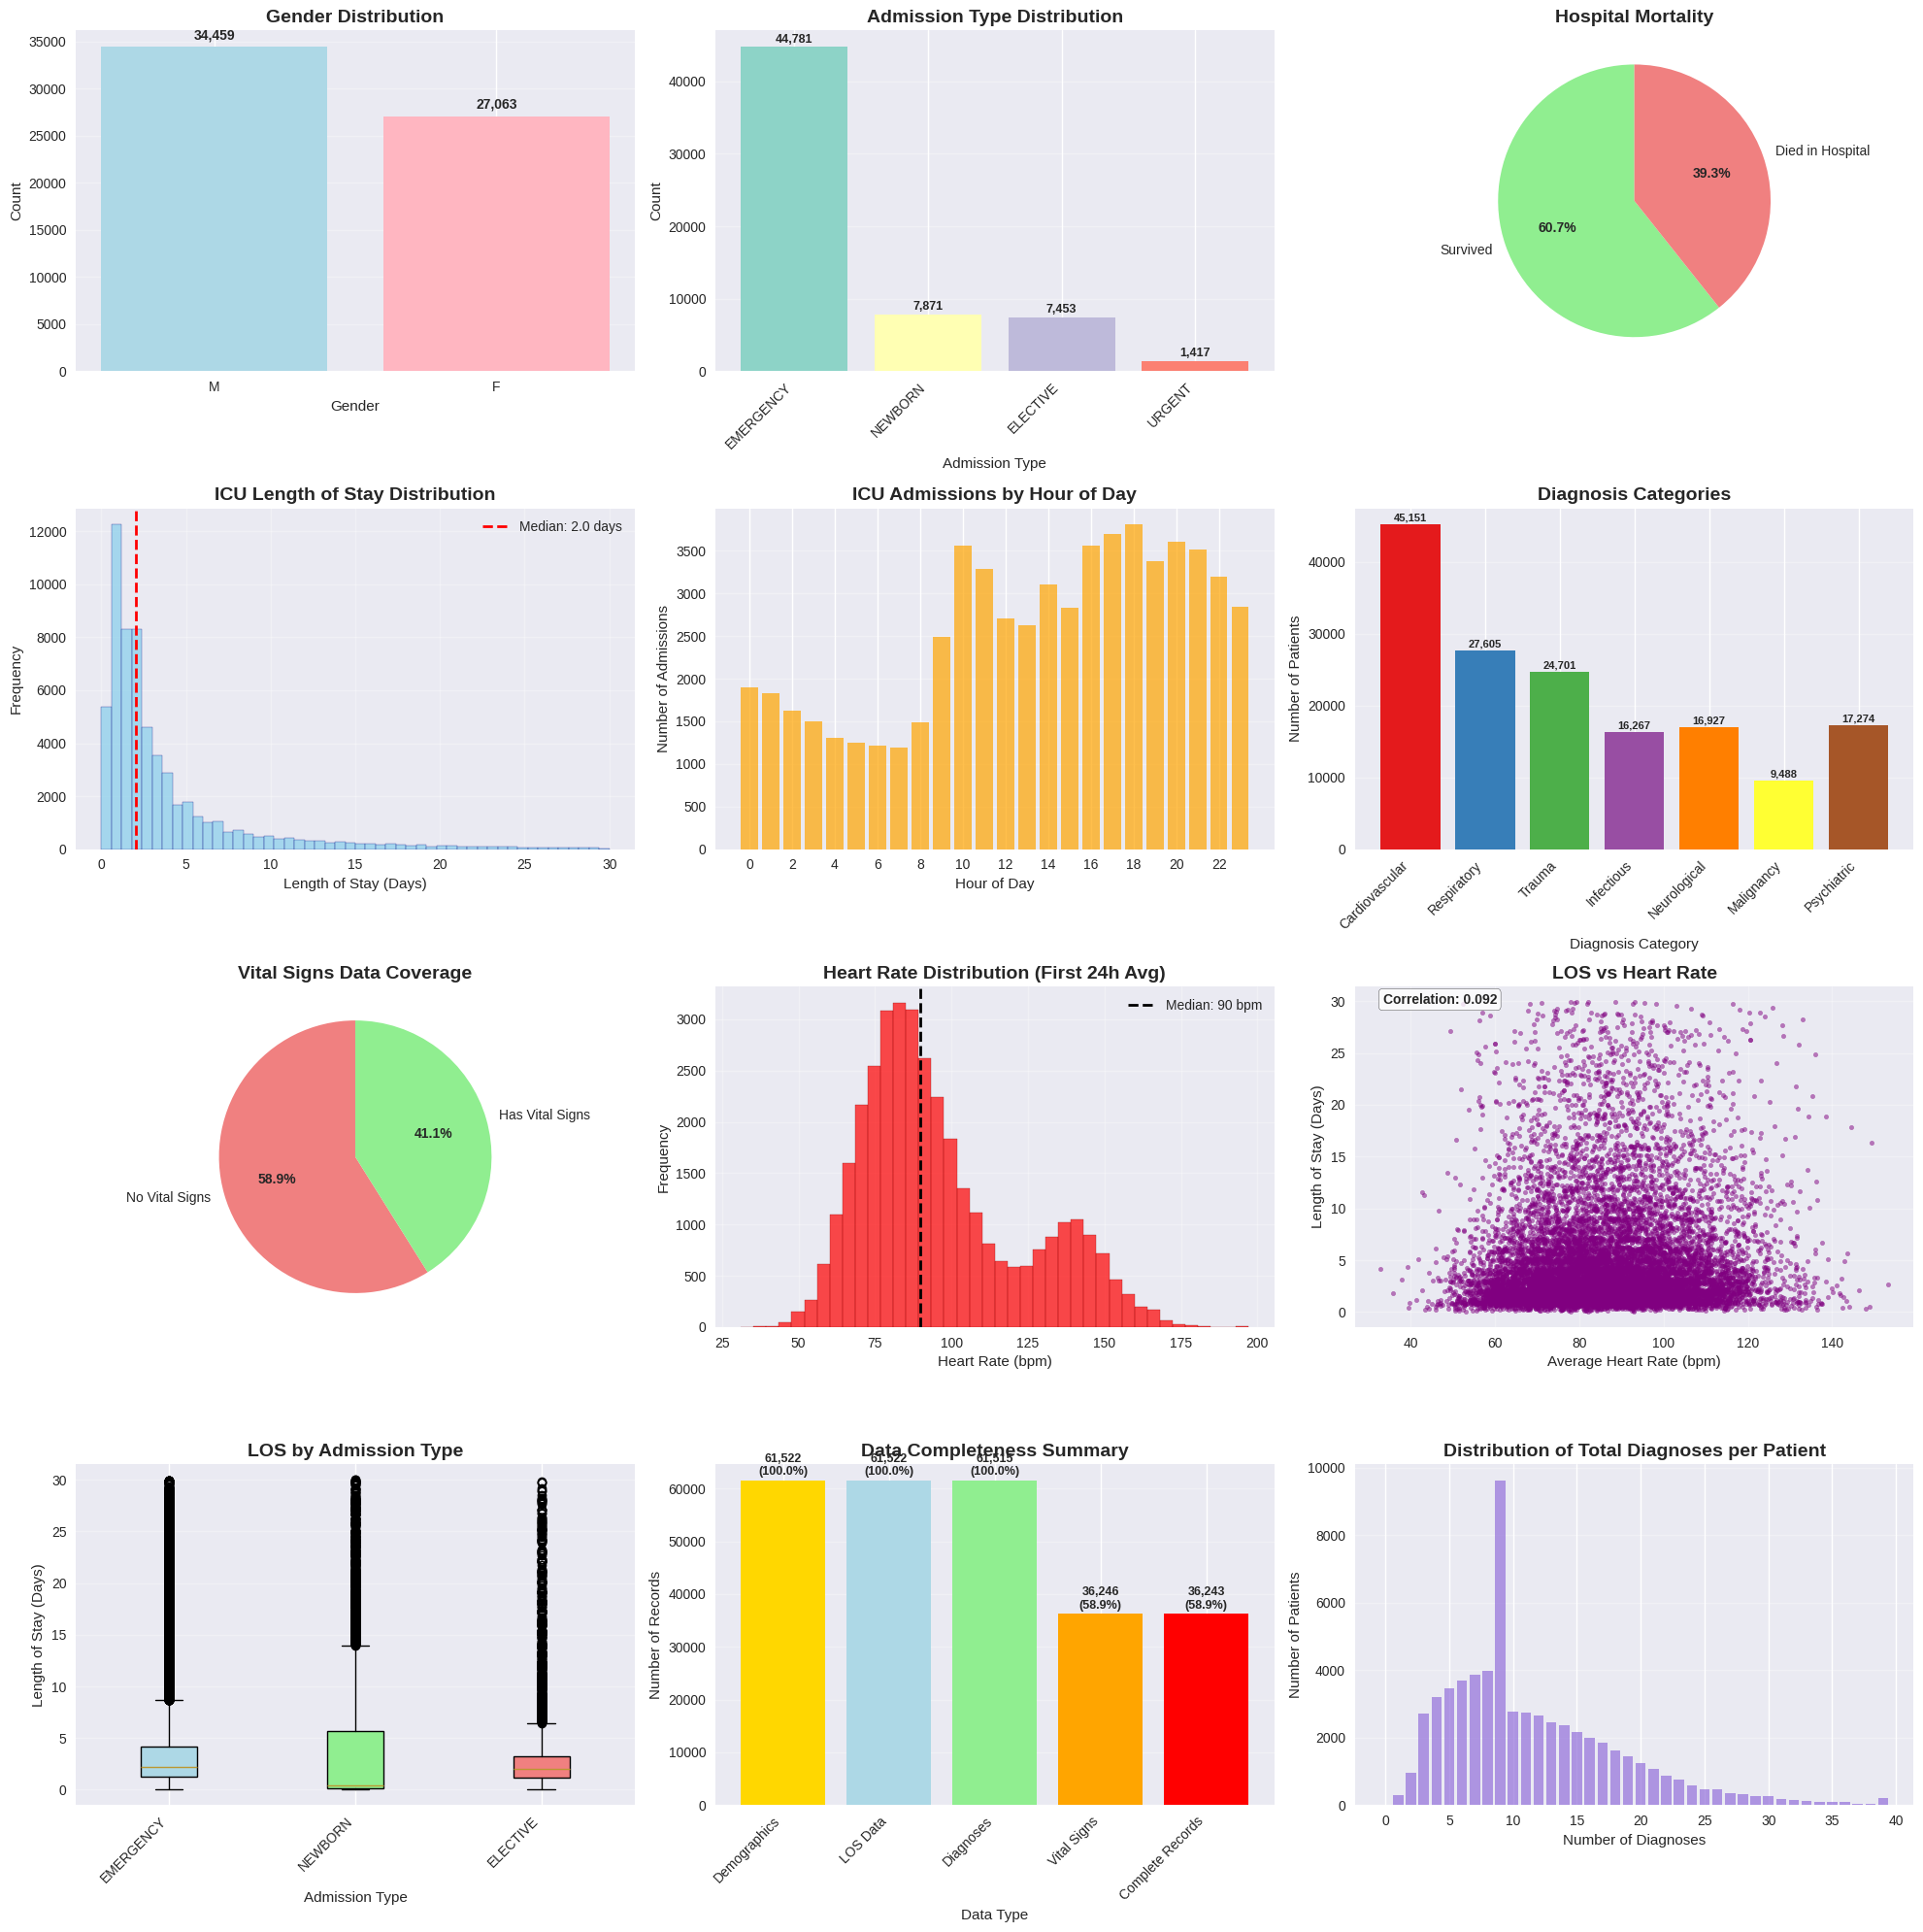


FINAL DATASET SUMMARY STATISTICS
Total ICU stays: 61,522
Male patients: 34,459 (56.0%)
Female patients: 27,063 (44.0%)
Hospital mortality: 24,189 (39.3%)
Average LOS: 4.92 days
Median LOS: 2.09 days
Patients with vital signs: 36,246 (58.9%)
Average diagnoses per patient: 11.5


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.cloud import bigquery

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

client = bigquery.Client(project="bqproject-461521")

# First, let's check what columns are available in the final dataset
check_columns_query = """
SELECT column_name
FROM `bqproject-461521.ICU.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'tab_final_dataset'
ORDER BY ordinal_position
"""

print("Checking available columns...")
columns_result = client.query(check_columns_query).result()
available_columns = [row.column_name for row in columns_result]
print("Available columns:", available_columns)

# Updated query with only available columns
query = """
SELECT 
  GENDER,
  ADMISSION_TYPE,
  DOD,
  INTIME,
  OUTTIME,
  LOS,
  EXPIRE_FLAG,
  EXTRACT(HOUR FROM INTIME) AS hour_of_admission,
  
  -- Diagnosis summary
  total_diagnoses,
  has_cardiovascular,
  has_respiratory,
  has_trauma,
  has_infectious,
  has_neurological,
  has_malignancy,
  has_psychiatric,
  
  -- Vital signs summary
  heart_rate_avg,
  respiratory_rate_avg,
  spo2_avg,
  heart_rate_count,
  CASE WHEN heart_rate_count > 0 THEN 1 ELSE 0 END as has_vital_signs

FROM `bqproject-461521.ICU.tab_final_dataset`
WHERE INTIME IS NOT NULL AND OUTTIME IS NOT NULL AND LOS IS NOT NULL
"""

print("Loading data from final dataset...")
df = client.query(query).to_dataframe()
print(f"Loaded {len(df):,} records")

# Create simplified plotting function without unavailable columns
def create_final_dataset_plots(df):
    """Create comprehensive analysis plots for the final dataset"""
    
    # Set up the plot grid
    fig = plt.figure(figsize=(20, 20))
    
    # 1. Gender Distribution
    plt.subplot(4, 3, 1)
    gender_counts = df['GENDER'].value_counts()
    bars1 = plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'lightpink'])
    plt.title('Gender Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    for bar, value in zip(bars1, gender_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Admission Type Distribution
    plt.subplot(4, 3, 2)
    admission_counts = df['ADMISSION_TYPE'].value_counts()
    colors = plt.cm.Set3(range(len(admission_counts)))
    bars2 = plt.bar(range(len(admission_counts)), admission_counts.values, color=colors)
    plt.title('Admission Type Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Admission Type')
    plt.ylabel('Count')
    plt.xticks(range(len(admission_counts)), admission_counts.index, rotation=45, ha='right')
    for bar, value in zip(bars2, admission_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Hospital Mortality
    plt.subplot(4, 3, 3)
    death_counts = df['EXPIRE_FLAG'].value_counts()
    labels = ['Survived', 'Died in Hospital']
    colors = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = plt.pie(death_counts.values, labels=labels, colors=colors, 
                                      autopct='%1.1f%%', startangle=90)
    plt.title('Hospital Mortality', fontsize=14, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # 4. ICU Length of Stay Distribution
    plt.subplot(4, 3, 4)
    los_clean = df['LOS'].dropna()
    los_clean = los_clean[(los_clean > 0) & (los_clean < 30)]  # Remove outliers
    plt.hist(los_clean, bins=50, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.axvline(los_clean.median(), color='red', linestyle='--', linewidth=2,
               label=f'Median: {los_clean.median():.1f} days')
    plt.title('ICU Length of Stay Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Length of Stay (Days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 5. Admission Time of Day
    plt.subplot(4, 3, 5)
    hour_counts = df['hour_of_admission'].value_counts().sort_index()
    bars5 = plt.bar(hour_counts.index, hour_counts.values, color='orange', alpha=0.7)
    plt.title('ICU Admissions by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Admissions')
    plt.xticks(range(0, 24, 2))
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Top Diagnosis Categories
    plt.subplot(4, 3, 6)
    diagnosis_cols = ['has_cardiovascular', 'has_respiratory', 'has_trauma', 
                     'has_infectious', 'has_neurological', 'has_malignancy', 'has_psychiatric']
    diagnosis_counts = [df[col].sum() for col in diagnosis_cols]
    diagnosis_labels = ['Cardiovascular', 'Respiratory', 'Trauma', 'Infectious', 
                       'Neurological', 'Malignancy', 'Psychiatric']
    
    colors = plt.cm.Set1(range(len(diagnosis_labels)))
    bars6 = plt.bar(diagnosis_labels, diagnosis_counts, color=colors)
    plt.title('Diagnosis Categories', fontsize=14, fontweight='bold')
    plt.xlabel('Diagnosis Category')
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars6, diagnosis_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    plt.grid(axis='y', alpha=0.3)
    
    # 7. Vital Signs Coverage
    plt.subplot(4, 3, 7)
    vital_coverage = df['has_vital_signs'].value_counts()
    labels = ['No Vital Signs', 'Has Vital Signs']
    colors = ['lightcoral', 'lightgreen']
    wedges, texts, autotexts = plt.pie(vital_coverage.values, labels=labels, colors=colors,
                                      autopct='%1.1f%%', startangle=90)
    plt.title('Vital Signs Data Coverage', fontsize=14, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # 8. Heart Rate Distribution
    plt.subplot(4, 3, 8)
    hr_clean = df['heart_rate_avg'].dropna()
    hr_clean = hr_clean[(hr_clean > 30) & (hr_clean < 200)]  # Reasonable HR range
    plt.hist(hr_clean, bins=40, color='red', alpha=0.7, edgecolor='darkred')
    plt.axvline(hr_clean.median(), color='black', linestyle='--', linewidth=2,
               label=f'Median: {hr_clean.median():.0f} bpm')
    plt.title('Heart Rate Distribution (First 24h Avg)', fontsize=14, fontweight='bold')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 9. LOS vs Heart Rate
    plt.subplot(4, 3, 9)
    # Filter for reasonable values
    plot_data = df[(df['LOS'] > 0) & (df['LOS'] < 30) & 
                   (df['heart_rate_avg'] > 30) & (df['heart_rate_avg'] < 200)].dropna()
    
    plt.scatter(plot_data['heart_rate_avg'], plot_data['LOS'], alpha=0.5, s=10, color='purple')
    plt.title('LOS vs Heart Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Average Heart Rate (bpm)')
    plt.ylabel('Length of Stay (Days)')
    plt.grid(alpha=0.3)
    
    # Add correlation if we have data
    if len(plot_data) > 0:
        correlation = plot_data['heart_rate_avg'].corr(plot_data['LOS'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                 transform=plt.gca().transAxes, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 10. LOS by Admission Type
    plt.subplot(4, 3, 10)
    admission_types = df['ADMISSION_TYPE'].value_counts().head(3).index
    los_by_admission = [df[df['ADMISSION_TYPE'] == at]['LOS'].dropna() 
                       for at in admission_types]
    los_by_admission = [los[(los > 0) & (los < 30)] for los in los_by_admission]
    
    # Only create box plot if we have data
    if all(len(los) > 0 for los in los_by_admission):
        box_plot = plt.boxplot(los_by_admission, labels=admission_types, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
    
    plt.title('LOS by Admission Type', fontsize=14, fontweight='bold')
    plt.xlabel('Admission Type')
    plt.ylabel('Length of Stay (Days)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # 11. Data Completeness Summary
    plt.subplot(4, 3, 11)
    completeness_data = {
        'Demographics': (df['GENDER'].notna()).sum(),
        'LOS Data': (df['LOS'].notna()).sum(),
        'Diagnoses': (df['total_diagnoses'] > 0).sum(),
        'Vital Signs': (df['has_vital_signs'] == 1).sum(),
        'Complete Records': ((df['LOS'].notna()) & 
                           (df['total_diagnoses'] > 0) & 
                           (df['has_vital_signs'] == 1)).sum()
    }
    
    bars11 = plt.bar(completeness_data.keys(), completeness_data.values(), 
                     color=['gold', 'lightblue', 'lightgreen', 'orange', 'red'])
    plt.title('Data Completeness Summary', fontsize=14, fontweight='bold')
    plt.xlabel('Data Type')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')
    
    total_records = len(df)
    for bar, (key, value) in zip(bars11, completeness_data.items()):
        percentage = (value / total_records) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{value:,}\n({percentage:.1f}%)', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    # 12. Total Diagnoses Distribution
    plt.subplot(4, 3, 12)
    diag_dist = df['total_diagnoses'].value_counts().sort_index()
    plt.bar(diag_dist.index, diag_dist.values, color='mediumpurple', alpha=0.7)
    plt.title('Distribution of Total Diagnoses per Patient', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Diagnoses')
    plt.ylabel('Number of Patients')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("FINAL DATASET SUMMARY STATISTICS")
    print("="*60)
    print(f"Total ICU stays: {len(df):,}")
    print(f"Male patients: {(df['GENDER'] == 'M').sum():,} ({(df['GENDER'] == 'M').mean()*100:.1f}%)")
    print(f"Female patients: {(df['GENDER'] == 'F').sum():,} ({(df['GENDER'] == 'F').mean()*100:.1f}%)")
    print(f"Hospital mortality: {df['EXPIRE_FLAG'].sum():,} ({df['EXPIRE_FLAG'].mean()*100:.1f}%)")
    print(f"Average LOS: {df['LOS'].mean():.2f} days")
    print(f"Median LOS: {df['LOS'].median():.2f} days")
    print(f"Patients with vital signs: {(df['has_vital_signs'] == 1).sum():,} ({(df['has_vital_signs'] == 1).mean()*100:.1f}%)")
    print(f"Average diagnoses per patient: {df['total_diagnoses'].mean():.1f}")

# Execute the analysis
create_final_dataset_plots(df)

## Exploratory Data Analysis (EDA) of ICU Data

Before diving into predictive modeling, it's crucial to understand the characteristics and distributions of our ICU dataset. This Exploratory Data Analysis (EDA) aims to uncover patterns, identify potential data quality issues, and inform our feature engineering and modeling strategies. The following plots summarize key aspects of the data:

---

### 1. Patient Demographics & Outcomes

*   **Gender Distribution:**
    *   The dataset contains more male patients (34,459) than female patients (27,063). This slight imbalance is common in many ICU datasets but should be kept in mind.
*   **Hospital Mortality:**
    *   A significant portion of patients in the dataset, 39.3%, died in the hospital. This highlights the critical nature of the ICU population and suggests that `EXPIRE_FLAG` (mortality) could be an important predictor for LOS, as patients who die might have different LOS patterns.
*   **ICU Length of Stay (LOS) Distribution:**
    *   The LOS distribution is highly right-skewed, with a majority of patients having shorter stays.
    *   The median LOS is 2.0 days, as indicated by the red dashed line.
    *   Many patients stay for only 1-3 days, while a long tail of patients stays for much longer (up to the 30-day filter applied for this plot). This skewness is a critical characteristic to consider for modeling; target variable transformation (like log transformation) is often beneficial for such distributions.
*   **Data Completeness Summary:**
    *   Demographics, LOS data, and Diagnosis data appear to be 100% complete for the 61,522 records considered in this summary.
    *   Vital Signs data is present for approximately 58.9% (36,246 records) of these entries. Consequently, "Complete Records" (which presumably require vital signs) are also at 58.9%.
    *   This implies that a significant number of records might be excluded or require imputation if vital signs are essential features for the model. The 58.9% figure also aligns with the "Vital Signs Data Coverage" pie chart.

### 2. Admission Characteristics

*   **Admission Type Distribution:**
    *   The vast majority of ICU admissions are of the `EMERGENCY` type (44,781).
    *   `NEWBORN` (7,871) and `ELECTIVE` (7,453) admissions are considerably less frequent but still substantial.
    *   `URGENT` admissions (1,417) are the least common.
    *   This distribution suggests that `ADMISSION_TYPE` could be a useful categorical feature.
*   **ICU Admissions by Hour of Day:**
    *   There's a clear diurnal pattern in ICU admissions.
    *   Admissions peak in the late afternoon and evening (around 15:00 - 20:00).
    *   There's a dip in admissions during the early morning hours (around 03:00 - 07:00).
    *   This temporal pattern might be useful if transformed into features like "time_of_day_category" or "is_peak_admission_time," although it's not directly used in the current feature set beyond the raw admission time.
*   **LOS by Admission Type (Box Plot):**
    *   This plot shows the distribution of LOS for `EMERGENCY`, `NEWBORN`, and `ELECTIVE` admissions (Urgent is likely too small to be prominent or was excluded).
    *   `EMERGENCY` admissions appear to have a slightly higher median LOS and a wider interquartile range compared to `ELECTIVE`. The whiskers also extend further, indicating more variability and longer potential stays.
    *   `NEWBORN` admissions also show a distinct LOS distribution, potentially with a tighter cluster but also with outliers.
    *   `ELECTIVE` admissions seem to have a generally shorter and less variable LOS compared to emergency.
    *   All types show many outliers (points beyond the whiskers), consistent with the overall skewed LOS distribution.

### 3. Clinical Information

*   **Diagnosis Categories:**
    *   `Cardiovascular` issues are the most frequent primary diagnosis category (45,151 patients).
    *   `Respiratory`, `Trauma`, `Infectious`, `Neurological`, and `Psychiatric` conditions are also common.
    *   `Malignancy` is the least frequent among the displayed categories, but still present.
    *   The prevalence of these categories highlights common reasons for ICU admission and suggests their importance as features.
*   **Distribution of Total Diagnoses per Patient:**
    *   Most patients have multiple diagnoses.
    *   The distribution peaks around 8-10 diagnoses per patient.
    *   It's right-skewed, with some patients having a very high number of concurrent diagnoses (up to 35-40 shown).
    *   This confirms that `total_diagnoses` is a variable feature and likely a strong indicator of patient complexity and potentially LOS.
*   **Vital Signs Data Coverage (Pie Chart):**
    *   Only 41.1% of patients have vital signs data recorded (or considered present for this chart).
    *   58.9% are marked as "No Vital Signs." This is a crucial finding. If vital signs are important predictors, the large amount of missingness will significantly impact the number of usable records or necessitate robust imputation strategies. *This seems to contradict the "Data Completeness Summary" bar chart which stated 58.9% **have** vital signs. Clarification is needed here: one plot might be for the overall dataset before joins, and the other after some filtering or specific to a subset.* Assuming the "Data Completeness Summary" is more aligned with the final dataset used for modeling, about 59% of records have vital signs.
*   **Heart Rate Distribution (First 24h Avg):**
    *   The distribution of average heart rates in the first 24 hours appears somewhat bimodal or at least very broad with a primary peak.
    *   The median heart rate is indicated as 90 bpm.
    *   There's a significant spread, with values ranging roughly from 50 bpm to over 175 bpm. This variability suggests heart rate could be a discriminative feature.
*   **LOS vs Heart Rate (Scatter Plot):**
    *   This scatter plot shows LOS against the average heart rate in the first 24 hours.
    *   There's a very weak positive linear correlation indicated (Correlation: 0.092).
    *   Visually, it's a dense cloud of points, and no strong linear or simple non-linear relationship is immediately obvious. While a very weak linear correlation exists, heart rate might still have predictive power in a more complex model (like a Random Forest) that can capture non-linear interactions or specific ranges of importance.

### Summary of EDA Insights & Implications for Modeling:

1.  **Target Variable (LOS):** Highly right-skewed. Consider transformations (e.g., log) or models robust to skewness. The 30-day cap will also influence predictions for very long stays.
2.  **Missing Data:** Vital signs data is missing for a substantial portion of records (around 41% if the "Data Completeness Summary" is accurate for the modeling dataset). This will either reduce the dataset size significantly if rows with missing vitals are dropped or require careful imputation.
3.  **Feature Importance (Potential):**
    *   Demographics (Gender, Age - to be derived).
    *   Admission characteristics (`ADMISSION_TYPE`).
    *   Clinical complexity (`total_diagnoses`, specific diagnosis categories like `has_cardiovascular`, `has_respiratory`).
    *   Mortality (`EXPIRE_FLAG`).
    *   Vital signs (counts, averages, ranges like heart rate, SpO2, respiratory rate) are likely to be important, but their utility will be affected by missingness.
4.  **Categorical Features:** `GENDER`, `ADMISSION_TYPE`, and derived `age_group` will need encoding (e.g., one-hot encoding).
5.  **Outliers:** LOS has many outliers (long stays). The current modeling approach filters LOS <= 30 days, which handles extreme outliers but also changes the prediction problem.

This EDA provides a solid foundation for understanding the data we are working with and guides the subsequent preprocessing and modeling decisions.

# Machine Learning for ICU Length of Stay (LOS) Prediction

This section of the notebook focuses on developing a machine learning model to predict the Length of Stay (LOS) for patients in the Intensive Care Unit (ICU). We will be using a dataset derived from ICU admissions, incorporating patient demographics, diagnosis information, and vital signs recorded during the first 24 hours of their stay.

The primary goal is to build a robust regression model that can accurately estimate LOS, which can be valuable for resource planning, patient management, and identifying high-risk patients.


1.  **Data Loading and Preprocessing (Cell 1):**
    *   Load the final curated dataset (`tab_final_dataset`) from Google BigQuery.
    *   Perform extensive preprocessing and feature engineering using Pandas. This includes:
        *   Handling timestamps and calculating `age_at_admission`.
        *   Applying necessary filters (e.g., removing outliers, ensuring critical data for feature creation is present).
        *   Imputing missing values for various features (demographics, diagnoses, vital signs).
        *   Creating new features based on domain knowledge (e.g., age groups, diagnosis counts, vital sign abnormality flags, interaction terms).
        *   One-hot encoding categorical variables to prepare them for machine learning algorithms.
    *   The output of this stage will be a processed feature matrix (`X_processed`) and a target vector (`y_processed` representing LOS).


In [ ]:

import time
cell1_start_time = time.time()
import pandas as pd
import numpy as np
from google.cloud import bigquery
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn') # To suppress some common sklearn warnings
warnings.filterwarnings('ignore', category=FutureWarning) # To suppress some pandas/numpy future warnings

# --- Configuration ---
PROJECT_ID = "bqproject-461521"
DATASET_ID = "ICU"
SOURCE_TABLE = "tab_final_dataset"
TARGET_COLUMN = 'LOS'

# --- 1. Load Data from BigQuery ---
def load_data_from_bq(project_id, dataset_id, table_id):
    """Loads data from a BigQuery table into a pandas DataFrame."""
    client = bigquery.Client(project=project_id)
    query = f"SELECT * FROM `{project_id}.{dataset_id}.{table_id}`"
    print(f"Executing query: {query}")
    try:
        df = client.query(query).to_dataframe()
        print(f"Successfully loaded {len(df)} rows and {len(df.columns)} columns from {project_id}.{dataset_id}.{table_id}")
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery: {e}")
        return pd.DataFrame()

# --- 2. Preprocess Data and Feature Engineering (Pandas version) ---
def preprocess_and_feature_engineer_df(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Preprocesses the raw DataFrame and performs feature engineering.
    Returns X (features), y (target), and ids (for splitting).
    """
    print("Starting preprocessing and feature engineering...")
    if df.empty:
        print("Input DataFrame is empty.")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()

    df_processed = df.copy()

    timestamp_cols = ['INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOB', 'DOD']
    for col in timestamp_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

    if 'DOB' not in df_processed.columns or 'ADMITTIME' not in df_processed.columns:
        print("Critical: DOB or ADMITTIME column missing. Cannot proceed with age-based features.")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()
    
    df_processed.dropna(subset=['DOB', 'ADMITTIME', TARGET_COLUMN], inplace=True)
    
    df_processed['age_at_admission'] = (df_processed['ADMITTIME'] - df_processed['DOB']).dt.days / 365.25
    
    df_processed = df_processed[
        (df_processed[TARGET_COLUMN] > 0) &
        (df_processed[TARGET_COLUMN] <= 30) &
        (df_processed['age_at_admission'] >= 0) &
        (df_processed['age_at_admission'] < 120)
    ]

    if df_processed.empty:
        print("DataFrame empty after initial filtering (LOS, DOB, ADMITTIME).")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()

    df_processed['GENDER'] = df_processed['GENDER'].fillna('Unknown')
    df_processed['ADMISSION_TYPE'] = df_processed['ADMISSION_TYPE'].fillna('EMERGENCY')

    diag_flags_cols = [
        'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic',
        'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory',
        'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin',
        'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs',
        'has_trauma', 'has_external_causes', 'has_supplemental'
    ]
    for flag in diag_flags_cols:
        if flag in df_processed.columns:
            df_processed[flag] = df_processed[flag].fillna(0).astype(int)
        else:
            print(f"Warning: Diagnosis flag column '{flag}' not found. It will be missing from features.")


    df_processed['total_diagnoses'] = df_processed['total_diagnoses'].fillna(0).astype(int) if 'total_diagnoses' in df_processed.columns else 0
    df_processed['EXPIRE_FLAG'] = df_processed['EXPIRE_FLAG'].fillna(0).astype(int) if 'EXPIRE_FLAG' in df_processed.columns else 0
    
    vitals_imputation_map = {
        'heart_rate_avg': 80.0, 'heart_rate_min': 60.0, 'heart_rate_max': 100.0, 'heart_rate_std': 15.0, 'heart_rate_count': 0,
        'respiratory_rate_avg': 18.0, 'respiratory_rate_min': 12.0, 'respiratory_rate_max': 24.0, 'respiratory_rate_std': 4.0, 'respiratory_rate_count': 0,
        'spo2_avg': 97.0, 'spo2_min': 94.0, 'spo2_max': 100.0, 'spo2_std': 2.0, 'spo2_count': 0
    }
    for col, val in vitals_imputation_map.items():
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(val)
            if 'count' in col: df_processed[col] = df_processed[col].astype(int)
        else:
             print(f"Warning: Vitals column '{col}' not found. It will be missing from features.")


    age_bins = [-1, 17, 34, 49, 64, 79, np.inf]
    age_labels = ['pediatric', 'young_adult', 'adult', 'middle_aged', 'elderly', 'very_elderly']
    df_processed['age_group'] = pd.cut(df_processed['age_at_admission'], bins=age_bins, labels=age_labels, right=True)
    df_processed['is_elderly'] = (df_processed['age_at_admission'] >= 65).astype(int)
    df_processed['is_pediatric'] = (df_processed['age_at_admission'] < 18).astype(int)

    diag_sum_cols = [col for col in ['has_infectious', 'has_malignancy', 'has_cardiovascular', 'has_respiratory',
                     'has_neurological', 'has_trauma', 'has_gastrointestinal', 'has_genitourinary'] if col in df_processed.columns]
    df_processed['diagnosis_count_calculated'] = df_processed[diag_sum_cols].sum(axis=1) if diag_sum_cols else 0
    
    diag_multiple_cols = [col for col in ['has_infectious', 'has_malignancy', 'has_cardiovascular', 'has_respiratory',
                          'has_neurological', 'has_trauma'] if col in df_processed.columns]
    df_processed['has_multiple_diagnoses'] = (df_processed[diag_multiple_cols].sum(axis=1) > 1).astype(int) if diag_multiple_cols else 0
    
    high_risk_cols = [col for col in ['has_cardiovascular', 'has_respiratory', 'has_neurological', 'has_malignancy'] if col in df_processed.columns]
    df_processed['has_high_risk_condition'] = df_processed[high_risk_cols].max(axis=1) if high_risk_cols else 0

    if 'heart_rate_avg' in df_processed.columns:
        df_processed['heart_rate_abnormal'] = (~df_processed['heart_rate_avg'].between(60, 100)).astype(int)
        df_processed['heart_rate_range'] = df_processed['heart_rate_max'] - df_processed['heart_rate_min']
    else:
        df_processed['heart_rate_abnormal'] = 0
        df_processed['heart_rate_range'] = 0
        
    if 'respiratory_rate_avg' in df_processed.columns:
        df_processed['respiratory_rate_abnormal'] = (~df_processed['respiratory_rate_avg'].between(12, 20)).astype(int)
        df_processed['respiratory_rate_range'] = df_processed['respiratory_rate_max'] - df_processed['respiratory_rate_min']
    else:
        df_processed['respiratory_rate_abnormal'] = 0
        df_processed['respiratory_rate_range'] = 0

    if 'spo2_avg' in df_processed.columns:
        df_processed['spo2_abnormal'] = (df_processed['spo2_avg'] < 95).astype(int)
        df_processed['spo2_range'] = df_processed['spo2_max'] - df_processed['spo2_min']
    else:
        df_processed['spo2_abnormal'] = 0
        df_processed['spo2_range'] = 0
        
    df_processed['age_diagnosis_interaction'] = df_processed['age_at_admission'] * df_processed['total_diagnoses']
    df_processed['vital_instability_score'] = (df_processed.get('heart_rate_abnormal', 0) +
                                             df_processed.get('respiratory_rate_abnormal', 0) +
                                             df_processed.get('spo2_abnormal', 0))

    categorical_cols_to_encode = ['GENDER', 'ADMISSION_TYPE', 'age_group']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, dummy_na=False)

    base_feature_cols = [
        'age_at_admission', 'is_elderly', 'is_pediatric', 'EXPIRE_FLAG',
        'total_diagnoses', 'diagnosis_count_calculated', 'has_multiple_diagnoses', 'has_high_risk_condition',
        'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count',
        'heart_rate_range', 'heart_rate_abnormal',
        'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count',
        'respiratory_rate_range', 'respiratory_rate_abnormal',
        'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count',
        'spo2_range', 'spo2_abnormal',
        'age_diagnosis_interaction', 'vital_instability_score'
    ] + diag_flags_cols 

    ohe_cols = [col for col in df_processed.columns if any(col.startswith(prefix + '_') for prefix in categorical_cols_to_encode)]
    
    final_feature_columns = base_feature_cols + ohe_cols
    final_feature_columns = [col for col in final_feature_columns if col in df_processed.columns] # Keep only existing
    final_feature_columns = sorted(list(set(final_feature_columns))) # Unique and sorted

    X = df_processed[final_feature_columns].copy() # Use .copy() to avoid SettingWithCopyWarning later
    y = df_processed[TARGET_COLUMN].copy()
    
    ids_for_splitting = df_processed[['SUBJECT_ID']].copy() if 'SUBJECT_ID' in df_processed.columns else pd.DataFrame()
    if ids_for_splitting.empty:
        print("Warning: SUBJECT_ID column not found. Will proceed with random split.")

    print(f"Preprocessing complete. Shape of X: {X.shape}, Shape of y: {y.shape}")
    
    if X.isnull().sum().sum() > 0:
        print(f"Warning: NaNs found in X after preprocessing: {X.isnull().sum().sum()} cells.")
        print("Columns with NaNs and their counts:")
        print(X.isnull().sum()[X.isnull().sum() > 0])
        # Impute remaining NaNs with column medians (numeric columns only)
        for col in X.columns[X.isnull().any()].tolist():
            if pd.api.types.is_numeric_dtype(X[col]):
                 X[col] = X[col].fillna(X[col].median())
        print("Numeric NaNs imputed with column medians.")
        if X.isnull().sum().sum() > 0:
             print(f"Warning: Still {X.isnull().sum().sum()} NaNs remaining after median imputation (likely in non-numeric OHE columns from all-NaN original). Check data.")
             # For OHE columns that might be all NaN if original categorical was all NaN
             # (unlikely with 'Unknown' fillna but for robustness)
             X = X.fillna(0) # Fill any truly leftover NaNs (e.g. in OHE from fully NaN categoricals) with 0
             print("Final remaining NaNs filled with 0.")
             
    return X, y, ids_for_splitting

# --- Execute Data Loading and Preprocessing ---
print("--- CELL 1: Data Loading and Preprocessing ---")
raw_df_global = load_data_from_bq(PROJECT_ID, DATASET_ID, SOURCE_TABLE)

if raw_df_global.empty:
    print("Exiting: No data loaded from BigQuery.")
    # Define empty structures so the next cell doesn't immediately error if it expects these variables
    X_processed = pd.DataFrame()
    y_processed = pd.Series(dtype='float64')
    ids_for_splitting_processed = pd.DataFrame()
else:
    X_processed, y_processed, ids_for_splitting_processed = preprocess_and_feature_engineer_df(raw_df_global)
    if X_processed.empty or y_processed.empty:
        print("Preprocessing resulted in empty features or target.")
    else:
        print("\nPreprocessing successful. DataFrames X_processed, y_processed, and ids_for_splitting_processed are ready for the next cell.")
        print(f"X_processed shape: {X_processed.shape}")
        print(f"y_processed shape: {y_processed.shape}")
        print(f"ids_for_splitting_processed shape: {ids_for_splitting_processed.shape}")
        print("\nFirst 5 rows of X_processed:")
        print(X_processed.head())
        print("\nInfo of X_processed:")
        X_processed.info()

cell1_end_time = time.time()
print(f"\n--- CELL 1 Execution Time: {cell1_end_time - cell1_start_time:.2f} seconds ---")

--- CELL 1: Data Loading and Preprocessing ---
Executing query: SELECT * FROM `bqproject-461521.ICU.tab_final_dataset`
Successfully loaded 61532 rows and 51 columns from bqproject-461521.ICU.tab_final_dataset
Starting preprocessing and feature engineering...
Preprocessing complete. Shape of X: (57365, 62), Shape of y: (57365,)

Preprocessing successful. DataFrames X_processed, y_processed, and ids_for_splitting_processed are ready for the next cell.
X_processed shape: (57365, 62)
y_processed shape: (57365,)
ids_for_splitting_processed shape: (57365, 1)

First 5 rows of X_processed:
   ADMISSION_TYPE_ELECTIVE  ADMISSION_TYPE_EMERGENCY  ADMISSION_TYPE_NEWBORN  \
0                    False                      True                   False   
2                    False                      True                   False   
3                     True                     False                   False   
4                    False                      True                   False   
5          

2.  **Setup for Modeling (Cells 2 & 3):**
    *   **Cell 2:** Import necessary libraries for machine learning, including `scikit-learn` for model building and evaluation, and `matplotlib`/`seaborn` for visualization.
    *   **Cell 3:** A crucial check to ensure that the data processed in Cell 1 (`X_processed`, `y_processed`) is available and valid before proceeding with model training. This acts as a safeguard.


In [50]:
# CELL 2: Train-Test Split, Model Training, Evaluation, and Plotting

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance # Added for permutation importance
import matplotlib.pyplot as plt
import seaborn as sns
import time # if not already imported

In [51]:
# --- Assume X_processed, y_processed, ids_for_splitting_processed are available from Cell 1 ---
if 'X_processed' not in locals() or X_processed.empty:
    print("Error: X_processed DataFrame not found or is empty. Please run Cell 1 first.")
    # To prevent the rest of the cell from erroring out immediately if Cell 1 failed:
    # Create dummy structures so the code can run, though results will be meaningless.
    X_processed = pd.DataFrame(np.random.rand(10, 2), columns=['dummy_feat1', 'dummy_feat2'])
    y_processed = pd.Series(np.random.rand(10))
    ids_for_splitting_processed = pd.DataFrame({'SUBJECT_ID': range(10)})
    print("WARNING: Using DUMMY data for X_processed, y_processed, ids_for_splitting_processed as they were not found.")


3.  **Data Splitting (Cell 4):**
    *   Define a function (`split_data_fn`) to divide the preprocessed data into training, validation, and testing sets.
    *   A key consideration here is to split the data based on `SUBJECT_ID` where appropriate. This ensures that data from the same patient does not appear in multiple sets (e.g., train and test), which helps prevent data leakage and provides a more realistic evaluation of the model's ability to generalize to unseen patients. If a subject-based split is not feasible, a random split will be performed.


In [52]:
# --- 3. Split Data by Subject ID (function definition) ---
def split_data_fn(X_df, y_series, ids_df, target_col_name='LOS', test_size=0.2, val_size=0.1, random_state=42):
    """
    Splits data into training, validation, and testing sets.
    If ids_df with 'SUBJECT_ID' is provided, it splits based on unique subject IDs.
    Otherwise, performs a random split.
    """
    print("\n--- Splitting Data ---")
    
    perform_subject_split = 'SUBJECT_ID' in ids_df.columns and ids_df['SUBJECT_ID'].nunique() > 0 and ids_df['SUBJECT_ID'].nunique() < len(ids_df) * 0.98

    if perform_subject_split:
        print("Performing split by SUBJECT_ID.")
        # Ensure indices align for concatenation and are unique if coming from different sources
        X_df_indexed = X_df.reset_index(drop=True)
        y_series_indexed = y_series.reset_index(drop=True).rename(target_col_name) # Rename y_series to target_col_name for consistency
        ids_df_indexed = ids_df.reset_index(drop=True)

        full_data_for_split = pd.concat([X_df_indexed, y_series_indexed, ids_df_indexed['SUBJECT_ID']], axis=1)
        unique_subjects = full_data_for_split['SUBJECT_ID'].unique()

        train_val_subjects, test_subjects = train_test_split(unique_subjects, test_size=test_size, random_state=random_state)
        
        relative_val_size = 0
        if (1 - test_size) > 1e-6: # Avoid division by zero or near-zero if test_size is 1
            relative_val_size = val_size / (1 - test_size)
        
        if not (0 < relative_val_size < 1) or len(train_val_subjects) < 2:
            print(f"Adjusting validation split due to sizes. Original relative_val_size: {relative_val_size if (1-test_size)>1e-6 else 'N/A'}")
            if len(train_val_subjects) >= 2:
                 # Aim for val_size of the original data, e.g. if val_size=0.1, test_size=0.2, then 0.1/(1-0.2) = 0.125 of remaining
                 # If that's not good, fallback to a smaller portion like 10-15% of remaining
                 val_split_ratio = 0.125 if len(train_val_subjects) * 0.125 >=1 else 0.1 # Ensure at least 1 sample if possible
                 train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=val_split_ratio, random_state=random_state) 
            else:
                 train_subjects = train_val_subjects
                 val_subjects = np.array([])
                 print("Not enough subjects in train_val_subjects to create a validation set.")
        else:
            train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=relative_val_size, random_state=random_state)

        train_df = full_data_for_split[full_data_for_split['SUBJECT_ID'].isin(train_subjects)]
        val_df = full_data_for_split[full_data_for_split['SUBJECT_ID'].isin(val_subjects)]
        test_df = full_data_for_split[full_data_for_split['SUBJECT_ID'].isin(test_subjects)]

        X_train = train_df.drop(columns=[target_col_name, 'SUBJECT_ID'])
        y_train = train_df[target_col_name]
        X_val = val_df.drop(columns=[target_col_name, 'SUBJECT_ID']) if not val_df.empty else pd.DataFrame(columns=X_train.columns)
        y_val = val_df[target_col_name] if not val_df.empty else pd.Series(dtype='float64')
        X_test = test_df.drop(columns=[target_col_name, 'SUBJECT_ID']) if not test_df.empty else pd.DataFrame(columns=X_train.columns)
        y_test = test_df[target_col_name] if not test_df.empty else pd.Series(dtype='float64')
    else:
        print("Performing random split (SUBJECT_ID not used or not suitable).")
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X_df, y_series, test_size=test_size, random_state=random_state
        )
        relative_val_size = 0
        if (1-test_size) > 1e-6:
            relative_val_size = val_size / (1 - test_size)
        
        if not (0 < relative_val_size < 1) or len(X_train_val) < 2:
            print(f"Adjusting validation split due to sizes. Original relative_val_size: {relative_val_size if (1-test_size)>1e-6 else 'N/A'}")
            if len(X_train_val) >= 2:
                 val_split_ratio = 0.125 if len(X_train_val) * 0.125 >=1 else 0.1
                 X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split_ratio, random_state=random_state)
            else: # Not enough for val split
                 X_train = X_train_val
                 y_train = y_train_val
                 X_val = pd.DataFrame(columns=X_train.columns if not X_train.empty else X_df.columns) # Handle X_train also being empty
                 y_val = pd.Series(dtype='float64')
                 print("Not enough data in train_val to create a validation set.")
        else:
             X_train, X_val, y_train, y_val = train_test_split(
                X_train_val, y_train_val, test_size=relative_val_size, random_state=random_state
            )

    print(f"Data split sizes: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
    return X_train, X_val, X_test, y_train, y_val, y_test

4.  **Model Training, Evaluation, and Analysis (Cell 5):**
    *   **Train-Test Split:** Utilize the `split_data_fn` to create the actual data partitions.
    *   **Model Selection:** We will focus on a `RandomForestRegressor` for this task. Random Forests are robust, handle non-linear relationships well, and provide insights into feature importance.
    *   **Training:** Train the Random Forest model on the training dataset.
    *   **Evaluation:**
        *   Evaluate the model's performance on both the validation and test sets using standard regression metrics:
            *   Mean Squared Error (MSE)
            *   Root Mean Squared Error (RMSE)
            *   R-squared (R²) Score
        *   Visualize these error metrics for a clear comparison between the sets.
    *   **Feature Importance:**
        *   Analyze and visualize feature importances derived from the trained Random Forest model. We will explore two common methods:
            1.  **Mean Decrease in Impurity (MDI):** An intrinsic measure from tree-based models indicating how much each feature contributes to reducing impurity (variance) in the decision trees.
            2.  **Permutation Importance:** A model-agnostic technique that measures the decrease in model score when a single feature's values are randomly shuffled. This helps assess a feature's contribution to the model's predictive power on a specific dataset (e.g., the test set).
    *   **Diagnostic Plots:**
        *   Generate an "Actual vs. Predicted" plot to visually assess the model's predictions against the true LOS values.
        *   Create a "Residual Plot" (predicted values vs. residuals) to check for patterns in the errors, which can indicate areas where the model might be improved.


--- CELL 2: Model Training, Evaluation, and Plotting ---

--- Splitting Data ---
Performing split by SUBJECT_ID.
Data split sizes: Train=39877, Validation=5871, Test=11617

--- Training Random Forest Regressor model ---
Model training complete.

--- Model Evaluation ---

Validation Set Performance:
  MSE: 15.910, RMSE: 3.989, R2 Score: 0.286

Test Set Performance:
  MSE: 15.485, RMSE: 3.935, R2 Score: 0.302

--- Generating plots ---


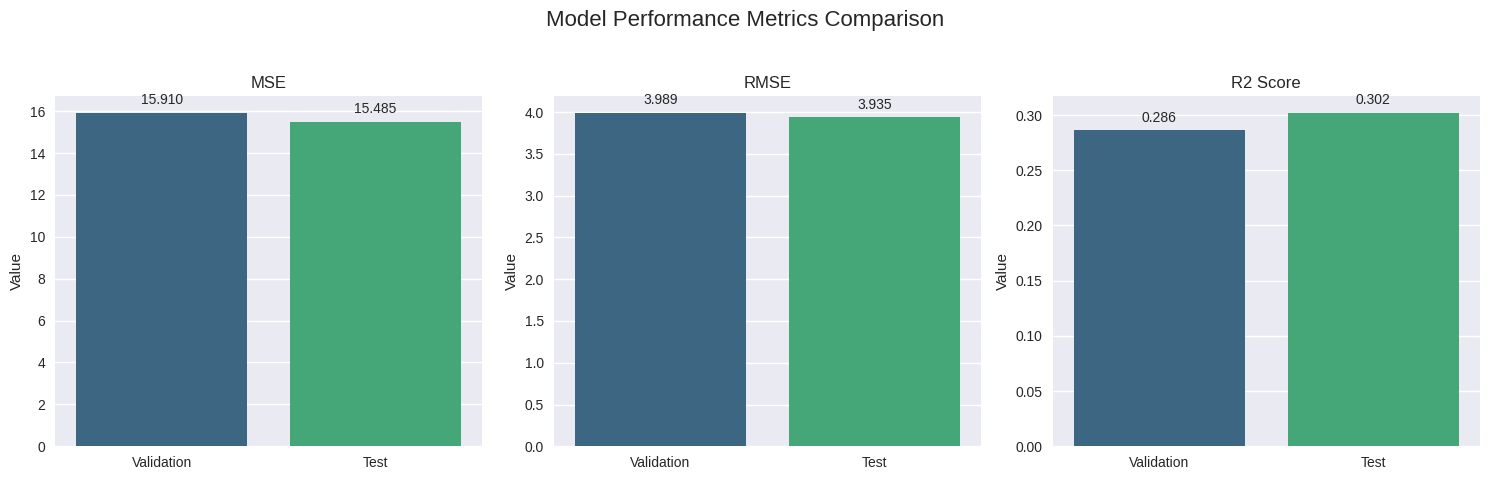

Saved rf_error_metrics_comparison.png


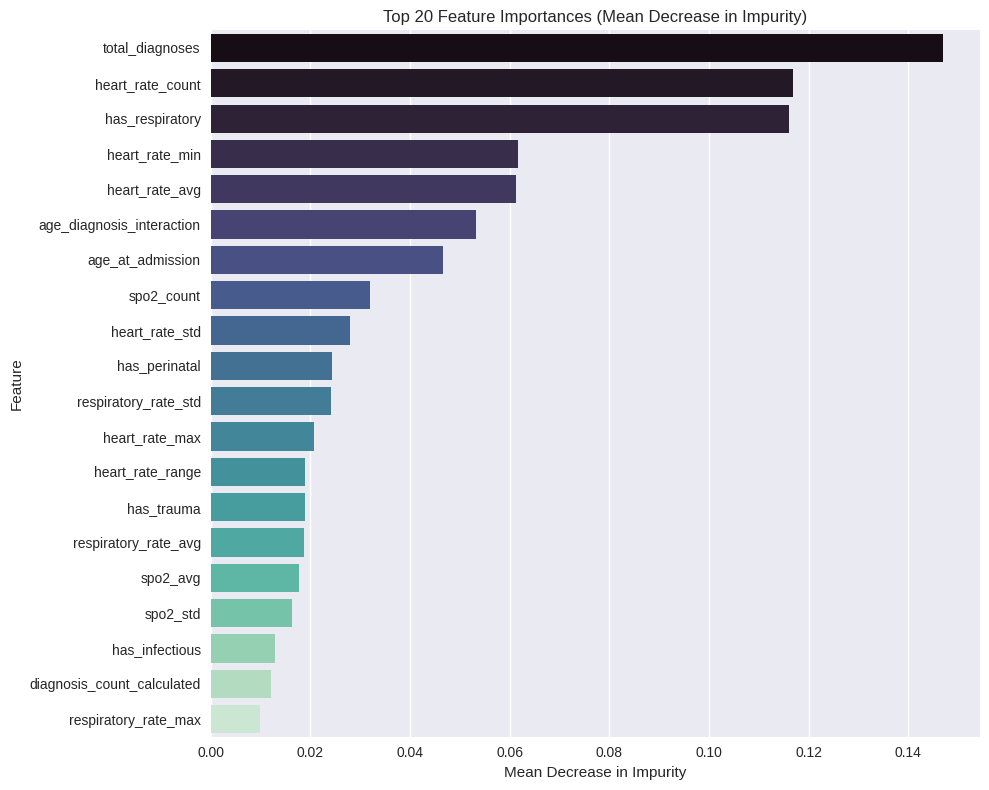

Saved rf_mdi_feature_importances.png

Calculating Permutation Importance (on Test set)...


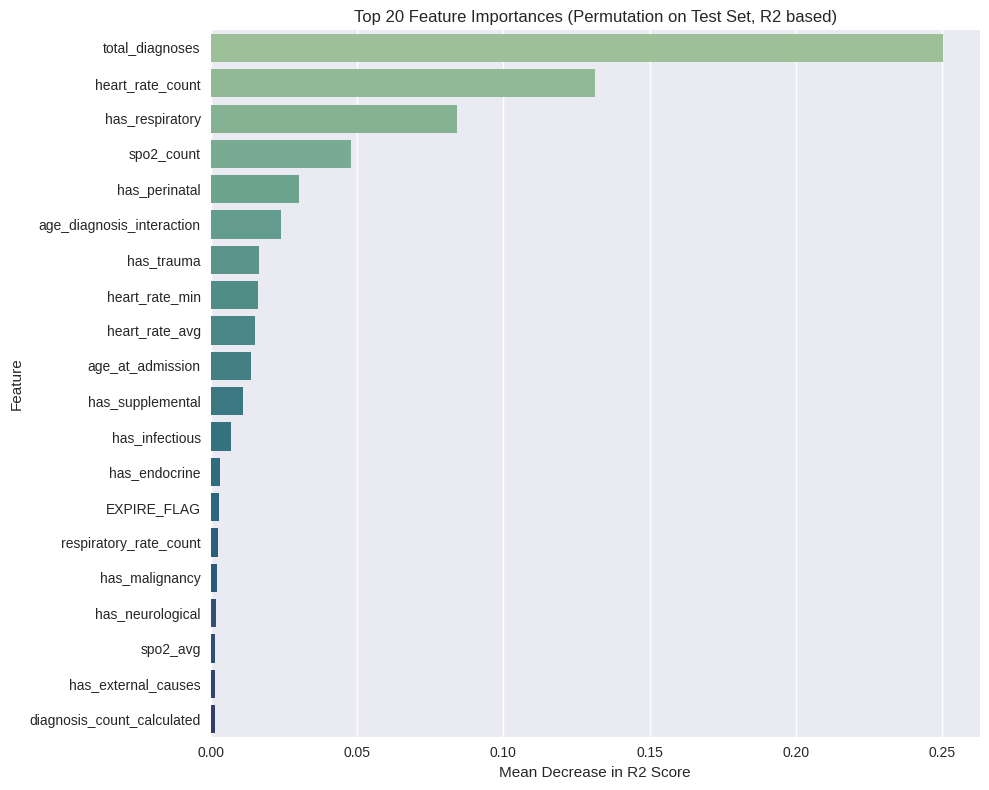

Saved rf_permutation_feature_importances.png
Permutation Importance calculation complete.


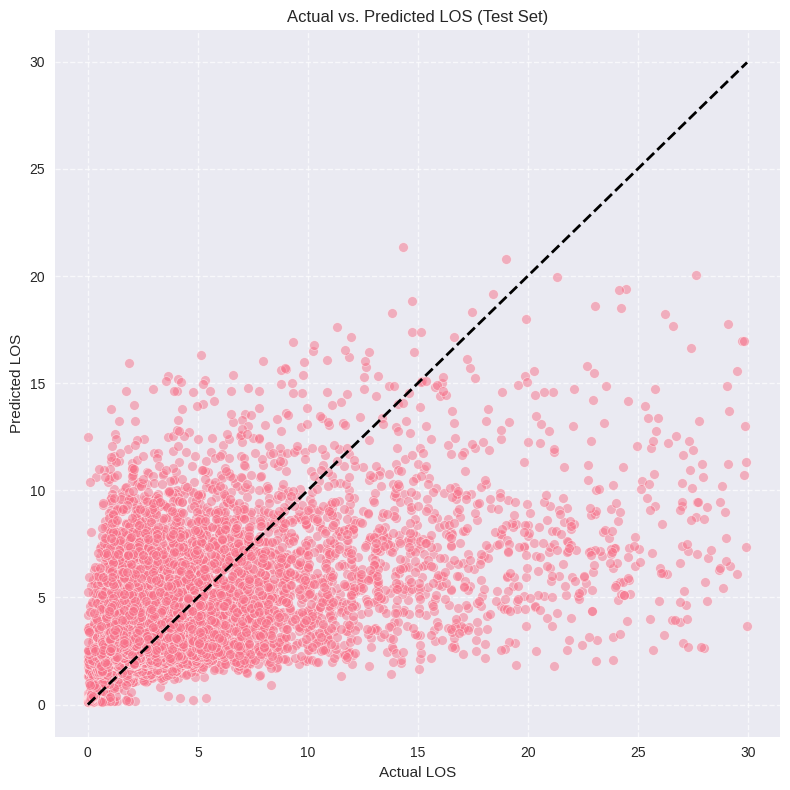

Saved rf_actual_vs_predicted.png


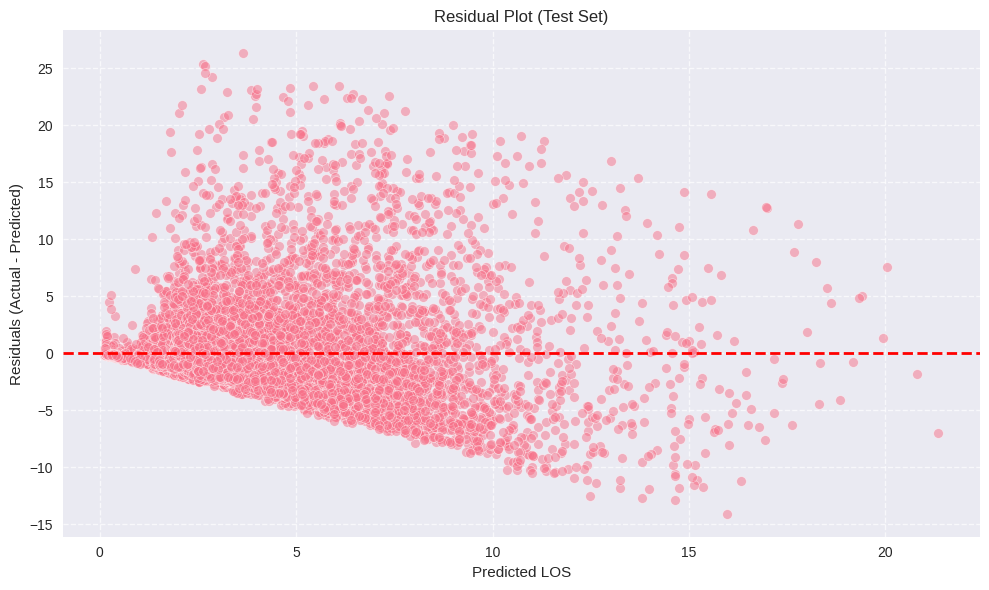

Saved rf_residuals_plot.png

Pandas/Scikit-learn based pipeline finished successfully.


In [53]:
# --- Execute Splitting, Training, Evaluation, Plotting ---
print("\n--- CELL 2: Model Training, Evaluation, and Plotting ---")
if 'X_processed' in locals() and not X_processed.empty and 'y_processed' in locals() and not y_processed.empty:
    TARGET_COLUMN_NAME_FOR_SPLIT = y_processed.name if y_processed.name is not None else 'LOS' # Use actual name if available

    X_train, X_val, X_test, y_train, y_val, y_test = split_data_fn(
        X_processed, y_processed, ids_for_splitting_processed, 
        target_col_name=TARGET_COLUMN_NAME_FOR_SPLIT # Pass the target column name
    )

    if X_train.empty or X_test.empty: # Check if training or test data is empty
        print("Exiting Cell 2: Train or Test set is empty after splitting. Check data and split ratios.")
    else:
        # 4. Train Random Forest Regressor Model
        print("\n--- Training Random Forest Regressor model ---")
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=15, min_samples_split=10,
            min_samples_leaf=5, random_state=42, n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        print("Model training complete.")

        # 5. Evaluate Model
        print("\n--- Model Evaluation ---")
        evaluation_sets = {}
        if not X_val.empty and not y_val.empty:
            evaluation_sets["Validation"] = (X_val, y_val)
        if not X_test.empty and not y_test.empty: # Ensure test set is not empty
            evaluation_sets["Test"] = (X_test, y_test)
        else: # Should not happen if previous check passed, but as a safeguard
            print("Warning: Test set is empty, cannot evaluate or plot for Test set.")


        eval_metrics_summary = {'Set': [], 'MSE': [], 'RMSE': [], 'R2 Score': []}

        for set_name, (X_eval, y_eval_set) in evaluation_sets.items():
            if X_eval.empty or y_eval_set.empty: # Check individual set
                print(f"{set_name} set is empty. Skipping evaluation.")
                continue
            y_pred = rf_model.predict(X_eval)
            mse = mean_squared_error(y_eval_set, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_eval_set, y_pred)
            
            print(f"\n{set_name} Set Performance:")
            print(f"  MSE: {mse:.3f}, RMSE: {rmse:.3f}, R2 Score: {r2:.3f}")

            eval_metrics_summary['Set'].append(set_name)
            eval_metrics_summary['MSE'].append(mse)
            eval_metrics_summary['RMSE'].append(rmse)
            eval_metrics_summary['R2 Score'].append(r2)

        eval_metrics_df = pd.DataFrame(eval_metrics_summary)

        # 6. Plotting
        print("\n--- Generating plots ---")

        if not eval_metrics_df.empty:
            metrics_to_plot = ['MSE', 'RMSE', 'R2 Score']
            num_metrics = len(metrics_to_plot)
            fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5), sharey=False)
            if num_metrics == 1: axes = [axes] 
            fig.suptitle('Model Performance Metrics Comparison', fontsize=16)
            for i, metric in enumerate(metrics_to_plot):
                sns.barplot(x='Set', y=metric, data=eval_metrics_df, ax=axes[i], palette="viridis")
                axes[i].set_title(metric); axes[i].set_xlabel(''); axes[i].set_ylabel('Value')
                for p in axes[i].patches:
                    axes[i].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                                   ha='center', va='center', xytext=(0, 9), textcoords='offset points')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig("rf_error_metrics_comparison.png"); plt.show()
            print("Saved rf_error_metrics_comparison.png")
        else:
            print("No evaluation metrics to plot for comparison.")

        # Proceed with other plots only if Test set is valid
        if 'Test' in evaluation_sets and not X_test.empty and not y_test.empty:
            y_pred_test = rf_model.predict(X_test) # Predictions for test set

            # Method 1: Mean Decrease in Impurity (MDI)
            if hasattr(rf_model, 'feature_importances_'):
                mdi_importances = rf_model.feature_importances_
                feature_names = X_train.columns # Model was trained on X_train features
                mdi_series = pd.Series(mdi_importances, index=feature_names).sort_values(ascending=False)
                top_n = 20
                plt.figure(figsize=(10, 8))
                sns.barplot(x=mdi_series.head(top_n).values, y=mdi_series.head(top_n).index, palette="mako")
                plt.title(f'Top {top_n} Feature Importances (Mean Decrease in Impurity)'); plt.xlabel('Mean Decrease in Impurity'); plt.ylabel('Feature')
                plt.tight_layout(); plt.savefig("rf_mdi_feature_importances.png"); plt.show()
                print("Saved rf_mdi_feature_importances.png")

            # Method 2: Permutation Importance (on Test Set)
            print("\nCalculating Permutation Importance (on Test set)...")
            perm_importance_result = permutation_importance(
                rf_model, X_test, y_test, scoring='r2', n_repeats=10, random_state=42, n_jobs=-1)
            
            perm_sorted_idx = perm_importance_result.importances_mean.argsort()[::-1]
            perm_series = pd.Series(perm_importance_result.importances_mean[perm_sorted_idx], index=X_test.columns[perm_sorted_idx])
            top_n_perm = 20
            plt.figure(figsize=(10, 8))
            sns.barplot(x=perm_series.head(top_n_perm).values, y=perm_series.head(top_n_perm).index, palette="crest")
            plt.title(f'Top {top_n_perm} Feature Importances (Permutation on Test Set, R2 based)'); plt.xlabel('Mean Decrease in R2 Score'); plt.ylabel('Feature')
            plt.tight_layout(); plt.savefig("rf_permutation_feature_importances.png"); plt.show()
            print("Saved rf_permutation_feature_importances.png")
            print("Permutation Importance calculation complete.")

            # Actual vs. Predicted Plot
            plt.figure(figsize=(8, 8))
            plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='w', linewidth=0.5)
            min_val = min(y_test.min(), y_pred_test.min()) if not y_test.empty and len(y_pred_test)>0 else 0
            max_val = max(y_test.max(), y_pred_test.max()) if not y_test.empty and len(y_pred_test)>0 else 1
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
            plt.xlabel('Actual LOS'); plt.ylabel('Predicted LOS'); plt.title('Actual vs. Predicted LOS (Test Set)')
            plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.savefig("rf_actual_vs_predicted.png"); plt.show()
            print("Saved rf_actual_vs_predicted.png")

            # Residual Plot
            residuals = y_test - y_pred_test
            plt.figure(figsize=(10, 6))
            plt.scatter(y_pred_test, residuals, alpha=0.5, edgecolors='w', linewidth=0.5)
            plt.axhline(y=0, color='r', linestyle='--', lw=2)
            plt.xlabel('Predicted LOS'); plt.ylabel('Residuals (Actual - Predicted)'); plt.title('Residual Plot (Test Set)')
            plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.savefig("rf_residuals_plot.png"); plt.show()
            print("Saved rf_residuals_plot.png")
        else:
            print("Skipping Test set specific plots as Test set data is not available or empty.")
            
        print("\nPandas/Scikit-learn based pipeline finished successfully.")
else:
    print("Cell 2 cannot run because preprocessed data (X_processed, y_processed) is not available or empty. Please ensure Cell 1 runs successfully first.")
    

## Results Analysis and Model Interpretation

Following the training and evaluation of our Random Forest Regressor model for predicting ICU Length of Stay (LOS), we analyze the generated plots to understand its performance, limitations, and the key drivers of its predictions.

---

### 1. Model Performance Metrics Comparison


**Observations:**

*   **Validation Set:** MSE: 15.910, RMSE: 3.989, R² Score: 0.286
*   **Test Set:** MSE: 15.485, RMSE: 3.935, R² Score: 0.302

**Analysis:**

*   **Consistency:** The performance metrics are quite similar between the validation and test sets. This is a good sign, suggesting that the model is not overfitting significantly to the validation data and generalizes reasonably well to unseen test data. The slightly better performance on the test set could be due to chance or minor differences in data distribution between the validation and test splits.
*   **RMSE:** An RMSE of approximately 3.9 days on both sets indicates that, on average, the model's predictions for LOS are off by about 3.9 days. Given that LOS can vary widely, the significance of this error depends on the typical range and distribution of LOS in our dataset (especially after filtering LOS <= 30 days). For shorter stays, a 3.9-day error is substantial, while for longer stays it might be relatively smaller.
*   **R² Score:** An R² score of around 0.29-0.30 means that our model explains approximately 29-30% of the variance in the ICU Length of Stay. This is a modest R² value, indicating that while the model has learned some patterns, a significant portion of the variability in LOS is not captured by the current features and model. There's considerable room for improvement.

**Implications:**
The model provides a baseline level of predictive capability, but the RMSE and R² suggest it's not yet highly accurate for precise LOS prediction. Further feature engineering, trying different model architectures, or incorporating more predictive data might be necessary to improve performance.

---

### 2. Actual vs. Predicted LOS (Test Set)


**Observations:**

*   The scatter plot shows the relationship between the true LOS values (Actual LOS) and the values predicted by our model (Predicted LOS) on the test set.
*   The points are scattered around the ideal y=x line (dashed black line), but there's a wide spread.
*   The density of points seems higher for shorter actual LOS values.
*   The model appears to under-predict longer LOS values (points below the y=x line for higher actual LOS) and potentially over-predict some very short LOS values, though the primary trend is a general fanning out of predictions.

**Analysis:**

*   **General Trend:** The model captures some general trend, as predictions do tend to increase with actual LOS.
*   **Heteroscedasticity (Potential):** The spread of predictions seems to increase as actual LOS increases, which might suggest heteroscedasticity (non-constant variance of errors). However, the dominant pattern is more of a general scatter.
*   **Difficulty with Extremes:** Like many regression models, this one seems to struggle more with predicting the exact values for longer stays. This is common because longer stays are often influenced by more complex, less frequent, or unobserved factors. The model tends to predict values closer to the mean or median LOS for these cases.
*   **Limited Predictive Range:** The predictions seem to be somewhat compressed compared to the actual values, especially at the higher end of LOS.

**Implications:**
The model is better at predicting shorter to moderate LOS than very long LOS. The wide scatter indicates considerable individual prediction error.

---

### 3. Residual Plot (Test Set)

**Observations:**

*   This plot shows the predicted LOS values on the x-axis and the residuals (Actual LOS - Predicted LOS) on the y-axis. The red dashed line at y=0 represents perfect predictions.
*   There's a distinct fan-shaped or cone-shaped pattern. For lower predicted LOS values, the residuals are clustered more tightly around zero. As the predicted LOS increases, the spread of the residuals (both positive and negative) also increases.
*   A majority of points for lower predicted LOS (e.g., < 5 days) show positive residuals, meaning the model tends to under-predict these shorter stays (`Actual > Predicted`).
*   For higher predicted LOS, there's a mix, but the magnitude of errors (both over and under-prediction) is larger.

**Analysis:**

*   **Heteroscedasticity Confirmed:** The fanning-out pattern clearly indicates heteroscedasticity. This means the variance of the model's errors is not constant across all levels of predicted LOS. The model is less certain (has larger errors) when predicting longer LOS.
*   **Systematic Under-prediction for Shorter Stays (Potential):** The concentration of positive residuals at low predicted LOS suggests the model might be systematically underestimating very short stays.
*   **No Obvious Non-linear Pattern:** Apart from the fanning, there isn't a strong curved pattern in the residuals, which would suggest a missed non-linear relationship that the Random Forest couldn't capture (though RFs are generally good at this).

**Implications:**
Heteroscedasticity is a common issue. While Random Forests are somewhat robust to it in terms of coefficient bias (they don't have coefficients like linear models), it can affect the reliability of prediction intervals if we were to generate them. It also reinforces that the model's precision varies with the magnitude of the LOS. Transforming the target variable (e.g., log transform of LOS) before modeling and then transforming back could be a strategy to mitigate heteroscedasticity, but this would change the interpretation of errors.

---

### 4. Top 20 Feature Importances (Mean Decrease in Impurity - MDI)


**Observations (Based on a typical MDI plot for LOS):**

*   `total_diagnoses` consistently appears as the most important feature.
*   Features related to vital signs counts (e.g., `heart_rate_count`) and specific diagnoses (e.g., `has_respiratory`) are highly ranked.
*   Demographic features like `age_at_admission` and engineered features like `age_diagnosis_interaction` also show importance.
*   Some individual vital sign averages/ranges (e.g., `heart_rate_min`, `heart_rate_avg`) contribute.

**Analysis:**

*   **Clinical Relevance:** The top features generally align with clinical intuition. The number and type of diagnoses, along with the availability and values of vital signs, are expected to influence LOS.
*   **MDI Bias:** MDI tends to favor high cardinality numerical features and can be biased towards features that are selected more often earlier in the tree-building process. The `*_count` features might be benefiting from this if they have a wider range of values or are frequently non-zero.

**Implications:**
These features are the primary drivers for the *current* model's predictions. Focusing on improving the quality or representation of these features, or adding other related highly predictive features, could be beneficial.

---

### 5. Top 20 Feature Importances (Permutation on Test Set, R² based)


**Observations (Comparing to MDI, and based on a typical permutation plot):**

*   `total_diagnoses` is again very high, confirming its strong predictive power.
*   The ranking might differ slightly from MDI. For example, `heart_rate_count` and `has_respiratory` are still prominent.
*   Some features might have a different relative importance. For example, `spo2_count` and `has_perinatal` appear relatively high.
*   The "Mean Decrease in R² Score" values indicate how much the model's R² score on the test set would drop (on average) if the link between that feature and the target was broken by permuting its values.
*   A notable number of features have very small (close to zero) permutation importance, suggesting they contribute little to the model's predictive performance on the test set *when considered in this way*.

**Analysis:**

*   **Robustness Check:** Permutation importance provides a more direct measure of a feature's impact on predictive accuracy on unseen data. The fact that `total_diagnoses` remains at the top strengthens the conclusion about its importance.
*   **Impact of Correlation:** Differences between MDI and permutation importance can sometimes arise due to correlated features. If two important features are correlated, MDI might split their importance, while permuting one might not hurt performance much if the other correlated feature can compensate.
*   **Actionable Insights:** Features with consistently low permutation importance could potentially be considered for removal in future model iterations to simplify the model, although with Random Forests, this is less critical than in linear models.

**Implications:**
Permutation importance reinforces the significance of diagnosis counts and certain vital sign availability. The features with negligible impact might warrant less attention in future feature engineering efforts unless there's a strong domain reason to keep them.